<a href="https://www.kaggle.com/code/jonathanradcliffe/3rd-comp-spaceship-titanic?scriptVersionId=125542431" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


#  Introduction

It seems the Spaceship Titanic collided with a spacetime anomaly en route to torrid 55 Cancri E. Almost half of the nearly 13000 passengers were transported to an alternative dimension. We've been enlisted to help rescue crews and retrieve the lost passengers by predicting which passengers are missing. 

To better mimic a real application I will create test & training data from the training data set. I will only use the test data for making preditions using my final model. 

* First we will import the test and train data. We will examine the two dataframes, see what's missing and decide how to deal with the missing data. Normally we aren't supposed to peak at our test dataframe, however we need to know how to deal with the missing data.
* Then we will explore the training data to get a sense of coorelations between features and the target as well as between features. 
* Next we will look at the trainings features in detail and see if any feature engineering or outlier exclusion is possible.
* Next we will check the numeric features for normal distributions. We will decide if transformation should be done at this point or as part of a pipeline after seperating into train/test. 
* Next we will onehotencode catagorical features. 
* We will have a final look at corelations before building models. 

* Update: for this version I'm going target use of catboost classifier. I'll reduce some of the feature engineering, scaling and normalisation to see what catboost classifier can do without my input. I've commented out my orginal approach. 

**Import libraries and dataframes!**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax, norm, skew

import warnings
warnings.filterwarnings("ignore")

from collections import Counter

pd.set_option('display.max_columns', 5000)
pd.set_option('display.max_rows', 5000)

sns.set(style='white', context='notebook', palette='colorblind')

#  Read and explore the train dataframe

In [3]:
train = pd.read_csv("/kaggle/input/spaceship-titanic/train.csv")
predict = pd.read_csv("/kaggle/input/spaceship-titanic/test.csv")

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [5]:
train.dtypes.value_counts()

object     7
float64    6
bool       1
dtype: int64

In [6]:
train.head()

PassengerId HomePlanet CryoSleep  Cabin  Destination   Age    VIP  \
0     0001_01     Europa     False  B/0/P  TRAPPIST-1e  39.0  False   
1     0002_01      Earth     False  F/0/S  TRAPPIST-1e  24.0  False   
2     0003_01     Europa     False  A/0/S  TRAPPIST-1e  58.0   True   
3     0003_02     Europa     False  A/0/S  TRAPPIST-1e  33.0  False   
4     0004_01      Earth     False  F/1/S  TRAPPIST-1e  16.0  False   

   RoomService  FoodCourt  ShoppingMall     Spa  VRDeck               Name  \
0          0.0        0.0           0.0     0.0     0.0    Maham Ofracculy   
1        109.0        9.0          25.0   549.0    44.0       Juanna Vines   
2         43.0     3576.0           0.0  6715.0    49.0      Altark Susent   
3          0.0     1283.0         371.0  3329.0   193.0       Solam Susent   
4        303.0       70.0         151.0   565.0     2.0  Willy Santantines   

   Transported  
0        False  
1         True  
2        False  
3        False  
4         True

#  Let's see what's missing from both the train and predict dataframes!

**Let's summarise what's missing and then review how to handle the missing data.**

In [7]:
missing_vals_train = pd.DataFrame(train.isna().sum(), columns=['Sum'])
missing_vals_train = missing_vals_train.sort_values(by = 'Sum', ascending=False)
missing_vals_train = missing_vals_train[missing_vals_train['Sum']>0]
missing_vals_train['Percent'] = missing_vals_train['Sum']/8693*100
missing_vals_train

Sum   Percent
CryoSleep     217  2.496261
ShoppingMall  208  2.392730
VIP           203  2.335212
HomePlanet    201  2.312205
Name          200  2.300702
Cabin         199  2.289198
VRDeck        188  2.162660
FoodCourt     183  2.105142
Spa           183  2.105142
Destination   182  2.093639
RoomService   181  2.082135
Age           179  2.059128

In terms of percentage the missing data is quite low. What's missing seems to be suprisingly close. I wonder if there is commonality between the missing data. Let's have a look after we see if there is anything we need to treat differently in the predict dataframe.

In [8]:
missing_vals_predict = pd.DataFrame(predict.isna().sum(), columns=['Sum'])
missing_vals_predict = missing_vals_predict.sort_values(by = 'Sum', ascending=False)
missing_vals_predict = missing_vals_predict[missing_vals_predict['Sum']>0]
missing_vals_predict['Percent'] = missing_vals_predict['Sum']/8693*100
missing_vals_predict

Sum   Percent
FoodCourt     106  1.219372
Spa           101  1.161854
Cabin         100  1.150351
ShoppingMall   98  1.127344
Name           94  1.081330
CryoSleep      93  1.069826
VIP            93  1.069826
Destination    92  1.058323
Age            91  1.046819
HomePlanet     87  1.000805
RoomService    82  0.943288
VRDeck         80  0.920281

Same story for the predict dataframe as the training dataframe

I've used the line of code below and can't see that there is multiple NaN per observation. We will need to look at each feature and make a determination how to treat the Nan. 

In [9]:
#train[train.isna().any(axis=1)] 

**The first feature to look at is CryoSleep**
* CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.

<AxesSubplot:xlabel='CryoSleep', ylabel='count'>

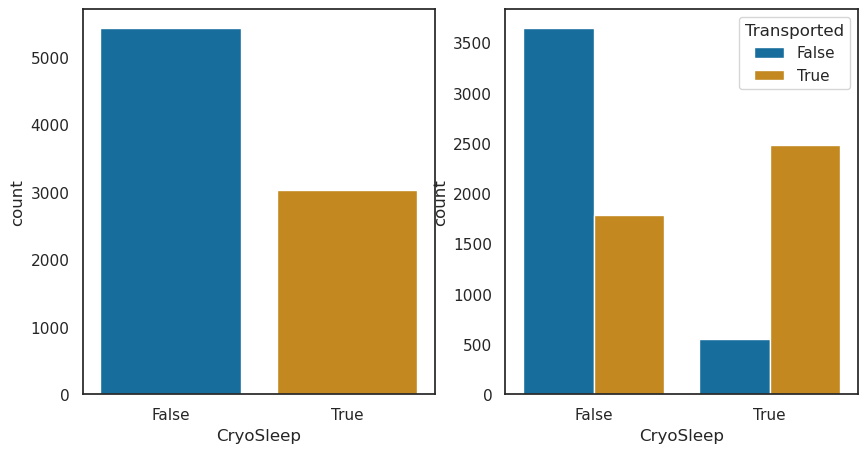

In [10]:
# categorical variable:  CryoSleep
fig, ax = plt.subplots(1,2, figsize =(10, 5))
sns.countplot(data=train, x='CryoSleep', ax=ax[0])
sns.countplot(data=train, x='CryoSleep', hue='Transported', ax=ax[1])

I'd like to replace the NaN in CryoSleep with True for those who were Transported and False for those who aren't. I won't because I can't apply this principle to the predict dataframe. So let's look at other features. 

<AxesSubplot:xlabel='Destination', ylabel='count'>

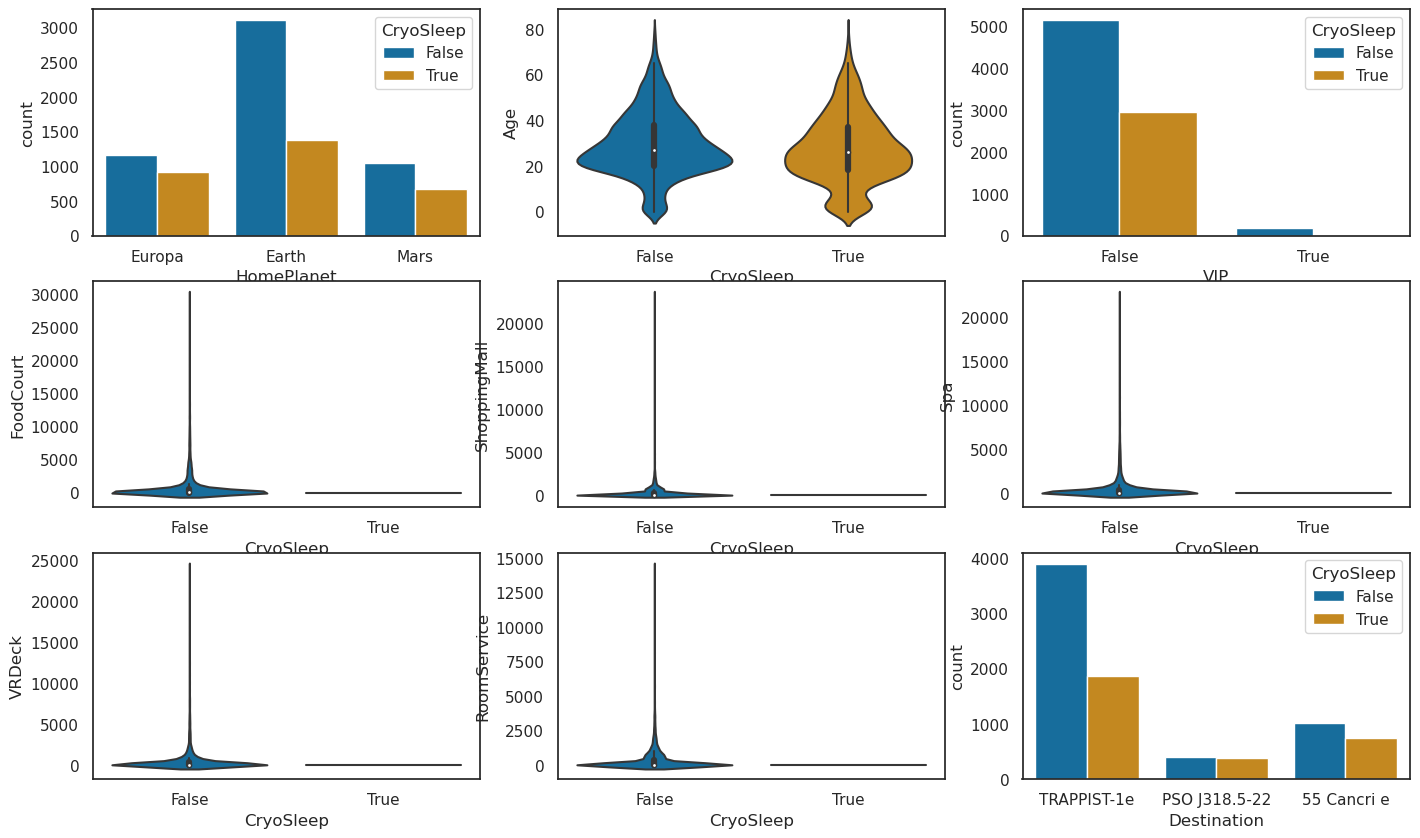

In [11]:
# categorical variable:  CryoSleep
fig, axs = plt.subplots(3,3, figsize =(17, 10))
sns.countplot(data=train, x='HomePlanet', hue='CryoSleep', ax=axs[0,0])
sns.violinplot(train, x = 'CryoSleep', y='Age', ax=axs[0,1])
sns.countplot(data=train, x='VIP', hue='CryoSleep', ax=axs[0,2])
sns.violinplot(train, x = 'CryoSleep', y='FoodCourt', ax=axs[1,0])
sns.violinplot(train, x = 'CryoSleep', y='ShoppingMall', ax=axs[1,1])
sns.violinplot(train, x = 'CryoSleep', y='Spa', ax=axs[1,2])
sns.violinplot(train, x = 'CryoSleep', y='VRDeck', ax=axs[2,0])
sns.violinplot(train, x = 'CryoSleep', y='RoomService', ax=axs[2,1])
sns.countplot(data=train, x='Destination', hue='CryoSleep', ax=axs[2,2])

* So it looks like those who spent money or were VIP all were False for CryoSleep
* It looks like those who are under ~ 10 years old are more likely to be in CryoSleep (remember this for feature engineering!)

**Looks like we would need to do some feature engineering to be more discerable.**
**For this version I'll make all the NaN False**

In [12]:
train['CryoSleep'] = train['CryoSleep'].fillna(False)
predict['CryoSleep'] = predict['CryoSleep'].fillna(False)

In [13]:
train['CryoSleep'].isnull().sum()

0

**The next features are the continuous features RoomService, FoodCourt, ShoppingMall, Spa, VRDeck**
* RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.

<AxesSubplot:xlabel='VRDeck', ylabel='Density'>

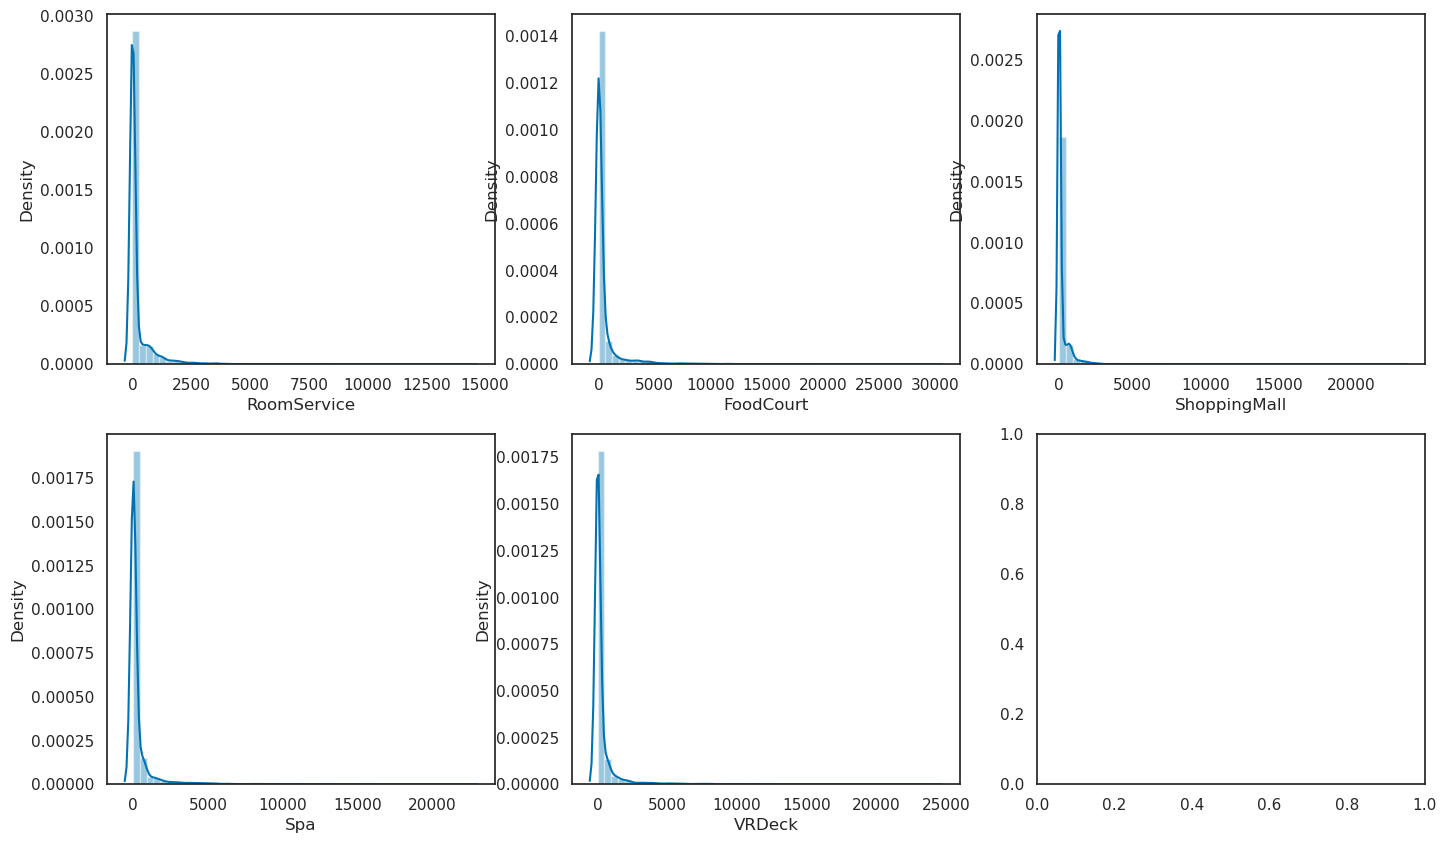

In [14]:
fig, axs = plt.subplots(2,3, figsize =(17, 10))
sns.distplot(train['RoomService'], ax=axs[0,0])
sns.distplot(train['FoodCourt'], ax=axs[0,1])
sns.distplot(train['ShoppingMall'], ax=axs[0,2])
sns.distplot(train['Spa'], ax=axs[1,0])
sns.distplot(train['VRDeck'], ax=axs[1,1])

Let's do this conditionally. Mode for any NaN of the feature if all the other features for that observation are 0. Else Median

In [15]:
condition1a = (train['RoomService'].isnull()) & ((train['FoodCourt'] > 0) | (train['ShoppingMall'] > 0) | (train['Spa'] > 0) | (train['VRDeck'] > 0))
choice1a = train['RoomService'].fillna(value=train['RoomService'].median())
train['RoomService'] = np.select([condition1a], [choice1a], default=train['RoomService'].fillna(value=0))

In [16]:
condition1b = (predict['RoomService'].isnull()) & ((predict['FoodCourt'] > 0) | (predict['ShoppingMall'] > 0) | (predict['Spa'] > 0) | (predict['VRDeck'] > 0))
choice1b = predict['RoomService'].fillna(value=predict['RoomService'].median())
predict['RoomService'] = np.select([condition1b], [choice1b], default=predict['RoomService'].fillna(value=0))

In [17]:
condition2a = (train['FoodCourt'].isnull()) & ((train['RoomService'] > 0) | (train['ShoppingMall'] > 0) | (train['Spa'] > 0) | (train['VRDeck'] > 0))
choice2a = train['FoodCourt'].fillna(value=train['FoodCourt'].median())
train['FoodCourt'] = np.select([condition2a], [choice2a], default=train['FoodCourt'].fillna(value=0))

condition2b = (predict['FoodCourt'].isnull()) & ((predict['RoomService'] > 0) | (predict['ShoppingMall'] > 0) | (predict['Spa'] > 0) | (predict['VRDeck'] > 0))
choice2b = predict['FoodCourt'].fillna(value=predict['FoodCourt'].median())
predict['FoodCourt'] = np.select([condition2b], [choice2b], default=predict['FoodCourt'].fillna(value=0))

In [18]:
condition3a = (train['ShoppingMall'].isnull()) & ((train['RoomService'] > 0) | (train['FoodCourt'] > 0) | (train['Spa'] > 0) | (train['VRDeck'] > 0))
choice3a = train['ShoppingMall'].fillna(value=train['ShoppingMall'].median())
train['ShoppingMall'] = np.select([condition2a], [choice2a], default=train['ShoppingMall'].fillna(value=0))

condition3b = (predict['ShoppingMall'].isnull()) & ((predict['RoomService'] > 0) | (predict['FoodCourt'] > 0) | (predict['Spa'] > 0) | (predict['VRDeck'] > 0))
choice3b = predict['ShoppingMall'].fillna(value=predict['ShoppingMall'].median())
predict['ShoppingMall'] = np.select([condition3b], [choice3b], default=predict['ShoppingMall'].fillna(value=0))

In [19]:
condition4a = (train['Spa'].isnull()) & ((train['RoomService'] > 0) | (train['FoodCourt'] > 0) | (train['ShoppingMall'] > 0) | (train['VRDeck'] > 0))
choice4a = train['Spa'].fillna(value=train['Spa'].median())
train['Spa'] = np.select([condition2a], [choice2a], default=train['Spa'].fillna(value=0))

condition4b = (predict['Spa'].isnull()) & ((predict['RoomService'] > 0) | (predict['FoodCourt'] > 0) | (predict['ShoppingMall'] > 0) | (predict['VRDeck'] > 0))
choice4b = predict['Spa'].fillna(value=predict['Spa'].median())
predict['Spa'] = np.select([condition4b], [choice4b], default=predict['Spa'].fillna(value=0))

In [20]:
condition5a = (train['VRDeck'].isnull()) & ((train['RoomService'] > 0) | (train['FoodCourt'] > 0) | (train['ShoppingMall'] > 0) | (train['Spa'] > 0))
choice5a = train['VRDeck'].fillna(value=train['VRDeck'].median())
train['VRDeck'] = np.select([condition5a], [choice5a], default=train['VRDeck'].fillna(value=0))

condition5b = (predict['VRDeck'].isnull()) & ((predict['RoomService'] > 0) | (predict['FoodCourt'] > 0) | (predict['ShoppingMall'] > 0) | (predict['Spa'] > 0))
choice5b = predict['VRDeck'].fillna(value=predict['VRDeck'].median())
predict['VRDeck'] = np.select([condition5b], [choice5b], default=predict['VRDeck'].fillna(value=0))

In [21]:
train['VRDeck'].isnull().sum()

0

**The next feature to look at is VIP**
* VIP - Whether the passenger has paid for special VIP service during the voyage

<AxesSubplot:xlabel='Destination', ylabel='count'>

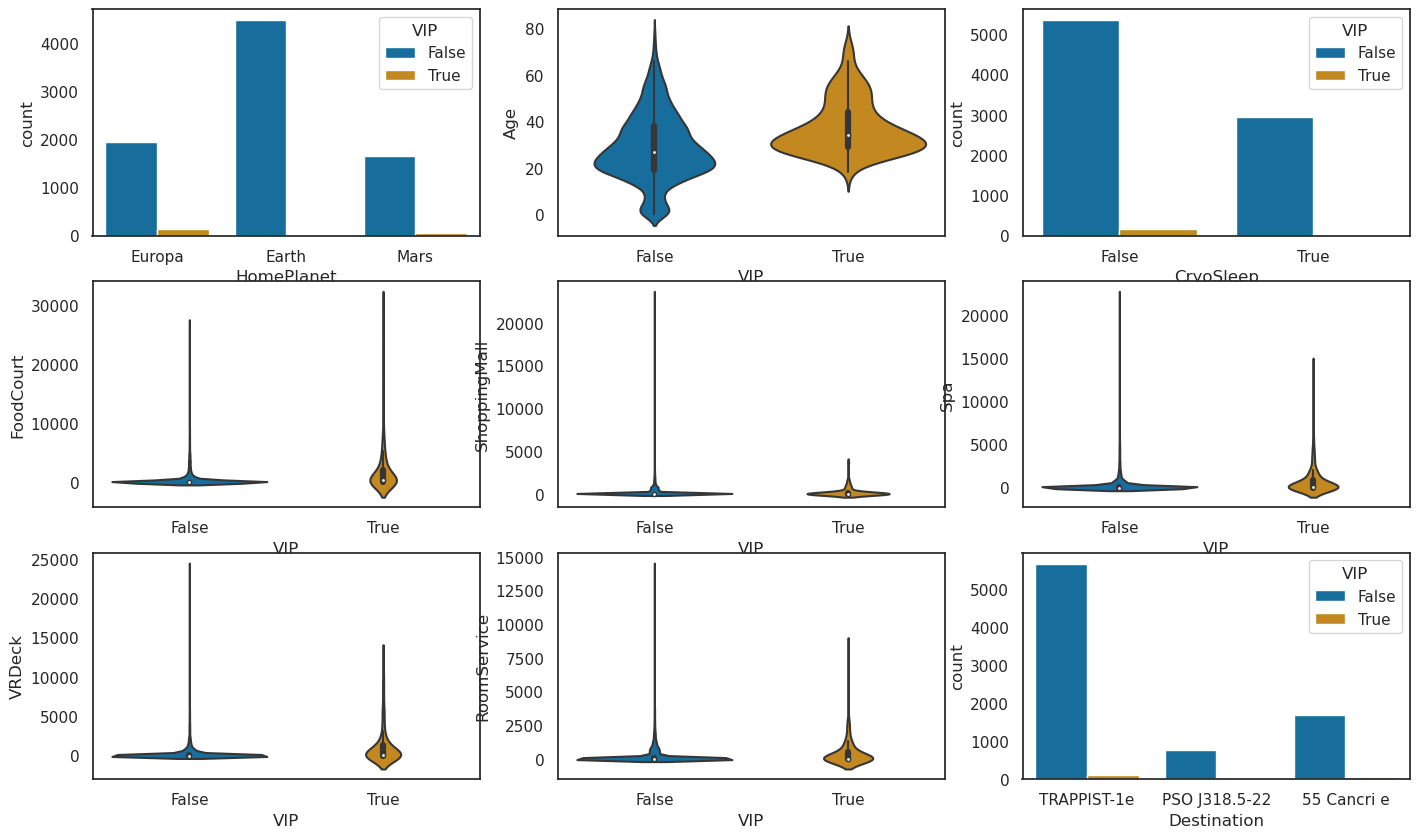

In [22]:
# categorical variable:  VIP
fig, axs = plt.subplots(3,3, figsize =(17, 10))
sns.countplot(data=train, x='HomePlanet', hue='VIP', ax=axs[0,0])
sns.violinplot(train, x = 'VIP', y='Age', ax=axs[0,1])
sns.countplot(data=train, x='CryoSleep', hue='VIP', ax=axs[0,2])
sns.violinplot(train, x = 'VIP', y='FoodCourt', ax=axs[1,0])
sns.violinplot(train, x = 'VIP', y='ShoppingMall', ax=axs[1,1])
sns.violinplot(train, x = 'VIP', y='Spa', ax=axs[1,2])
sns.violinplot(train, x = 'VIP', y='VRDeck', ax=axs[2,0])
sns.violinplot(train, x = 'VIP', y='RoomService', ax=axs[2,1])
sns.countplot(data=train, x='Destination', hue='VIP', ax=axs[2,2])

* No VIPs from Earth :( 
* Older folk more likely to be VIP
* Hard to say much about VIP and cash spend

**Looks like we would need to do some feature engineering to be more discerable.**
**For this version I'll make all the NaN False**

In [23]:
train['VIP'] = train['VIP'].fillna(False)
predict['VIP'] = predict['VIP'].fillna(False)

**The next feature to look at is HomePlanet**
* HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.

<AxesSubplot:xlabel='HomePlanet', ylabel='count'>

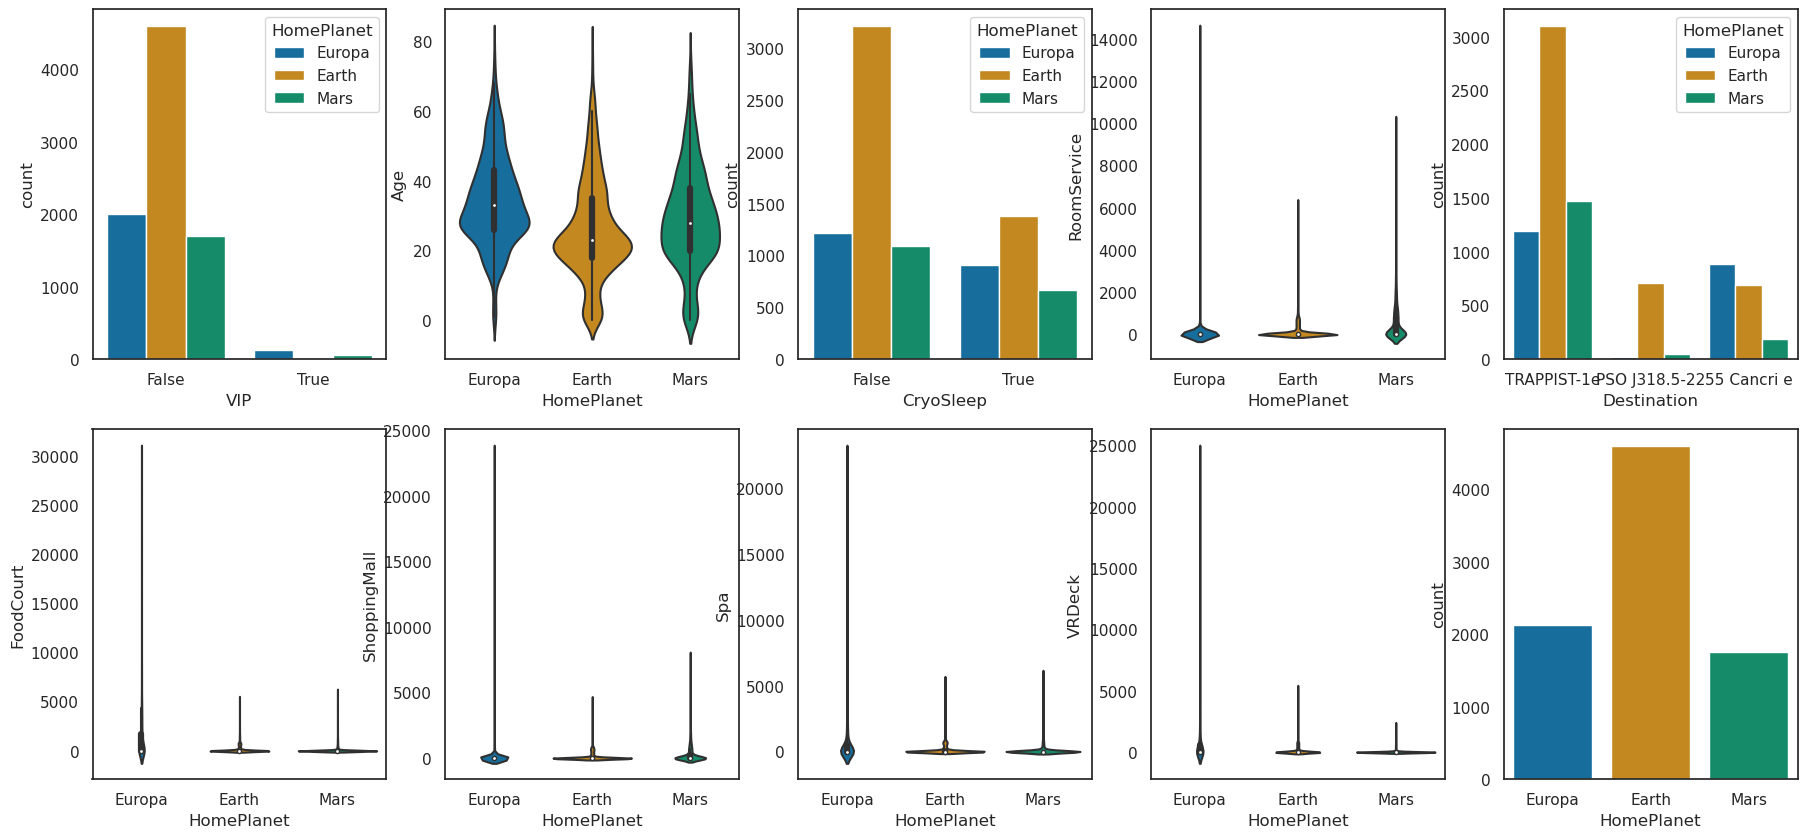

In [24]:
# categorical variable:  HomePlanet
fig, axs = plt.subplots(2,5, figsize =(22, 10))
sns.countplot(data=train, x='VIP', hue='HomePlanet', ax=axs[0,0])
sns.violinplot(train, x = 'HomePlanet', y='Age', ax=axs[0,1])
sns.countplot(data=train, x='CryoSleep', hue='HomePlanet', ax=axs[0,2])
sns.violinplot(train, x = 'HomePlanet', y='RoomService', ax=axs[0,3])
sns.countplot(data=train, x='Destination', hue='HomePlanet', ax=axs[0,4])
sns.violinplot(train, x = 'HomePlanet', y='FoodCourt', ax=axs[1,0])
sns.violinplot(train, x = 'HomePlanet', y='ShoppingMall', ax=axs[1,1])
sns.violinplot(train, x = 'HomePlanet', y='Spa', ax=axs[1,2])
sns.violinplot(train, x = 'HomePlanet', y='VRDeck', ax=axs[1,3])
sns.countplot(data=train, x='HomePlanet', ax=axs[1,4])

* Most frequent is Earth
* FoodCourt, ShoppingMall, Spa, VRDeck > 10000 is Europa\

**Let's say for HomePlanet fillna as Europa if FoodCourt, ShoppingMall, Spa, VRDeck are greater than 10k. Else Earth**

In [25]:
condition6a = (train['HomePlanet'].isnull()) & ((train['FoodCourt'] > 9000) | (train['ShoppingMall'] > 10000) | (train['Spa'] > 8000) | (train['VRDeck'] > 7000))
choice6a = train['HomePlanet'].fillna('Europa')
train['HomePlanet'] = np.select([condition6a], [choice6a], default=train['HomePlanet'].fillna('Earth'))

condition6b = (predict['HomePlanet'].isnull()) & ((predict['FoodCourt'] > 9000) | (predict['ShoppingMall'] > 10000) | (predict['Spa'] > 8000) | (predict['VRDeck'] > 7000))
choice6b = predict['HomePlanet'].fillna('Europa')
predict['HomePlanet'] = np.select([condition6b], [choice6b], default=predict['HomePlanet'].fillna('Earth'))

**The next feature to look at is Name**
* Name - The first and last names of the passenger.
* Reckon I might be able to drop this

In [26]:
train['Name'].value_counts()

Gollux Reedall        2
Elaney Webstephrey    2
Grake Porki           2
Sus Coolez            2
Apix Wala             2
                     ..
Jamela Griffy         1
Hardy Griffy          1
Salley Mckinn         1
Mall Frasp            1
Propsh Hontichre      1
Name: Name, Length: 8473, dtype: int64

In [27]:
# too much hassle! Let's drop it
train = train.drop(['Name'], axis=1)
predict = predict.drop(['Name'], axis=1)

**The next feature to look at is Cabin**
* Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
* This will take some feature engineering

In [28]:
train['Cabin'].value_counts()

G/734/S     8
G/109/P     7
B/201/P     7
G/1368/P    7
G/981/S     7
           ..
G/556/P     1
E/231/S     1
G/545/S     1
G/543/S     1
F/947/P     1
Name: Cabin, Length: 6560, dtype: int64

In [29]:
train['Cabin']

0          B/0/P
1          F/0/S
2          A/0/S
3          A/0/S
4          F/1/S
          ...   
8688      A/98/P
8689    G/1499/S
8690    G/1500/S
8691     E/608/S
8692     E/608/S
Name: Cabin, Length: 8693, dtype: object

* Let's create three functions which will return deck/num/side respectively.

In [30]:
train['Cabin'] = train['Cabin'].fillna('replace/replace/replace')
predict['Cabin'] = predict['Cabin'].fillna('replace/replace/replace')

In [31]:
# get split cabin
def get_cabin(cabin):
    step_1 = cabin.split('/')
    deck = step_1[0]
    num = step_1[1]
    side = step_1[2]
    
    return deck, num, side

In [32]:
cabins_train = train['Cabin']
decks_train = []
nums_train = []
sides_train = []
for cabin_train in cabins_train:
    result_train = get_cabin(cabin_train)
    decks_train.append(result_train[0])
    nums_train.append(result_train[1])
    sides_train.append(result_train[2])
train['Deck'] = decks_train
train['Num'] = nums_train
train['Side'] = sides_train

cabins_predict = predict['Cabin']
decks_predict = []
nums_predict = []
sides_predict = []
for cabin_predict in cabins_predict:
    result_predict = get_cabin(cabin_predict)
    decks_predict.append(result_predict[0])
    nums_predict.append(result_predict[1])
    sides_predict.append(result_predict[2])
predict['Deck'] = decks_predict
predict['Num'] = nums_predict
predict['Side'] = sides_predict

In [33]:
train.head()
train = train.drop(['Cabin'], axis=1)
predict = predict.drop(['Cabin'], axis=1)

**The next feature to look at is Deck**
* Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.

<AxesSubplot:xlabel='HomePlanet', ylabel='count'>

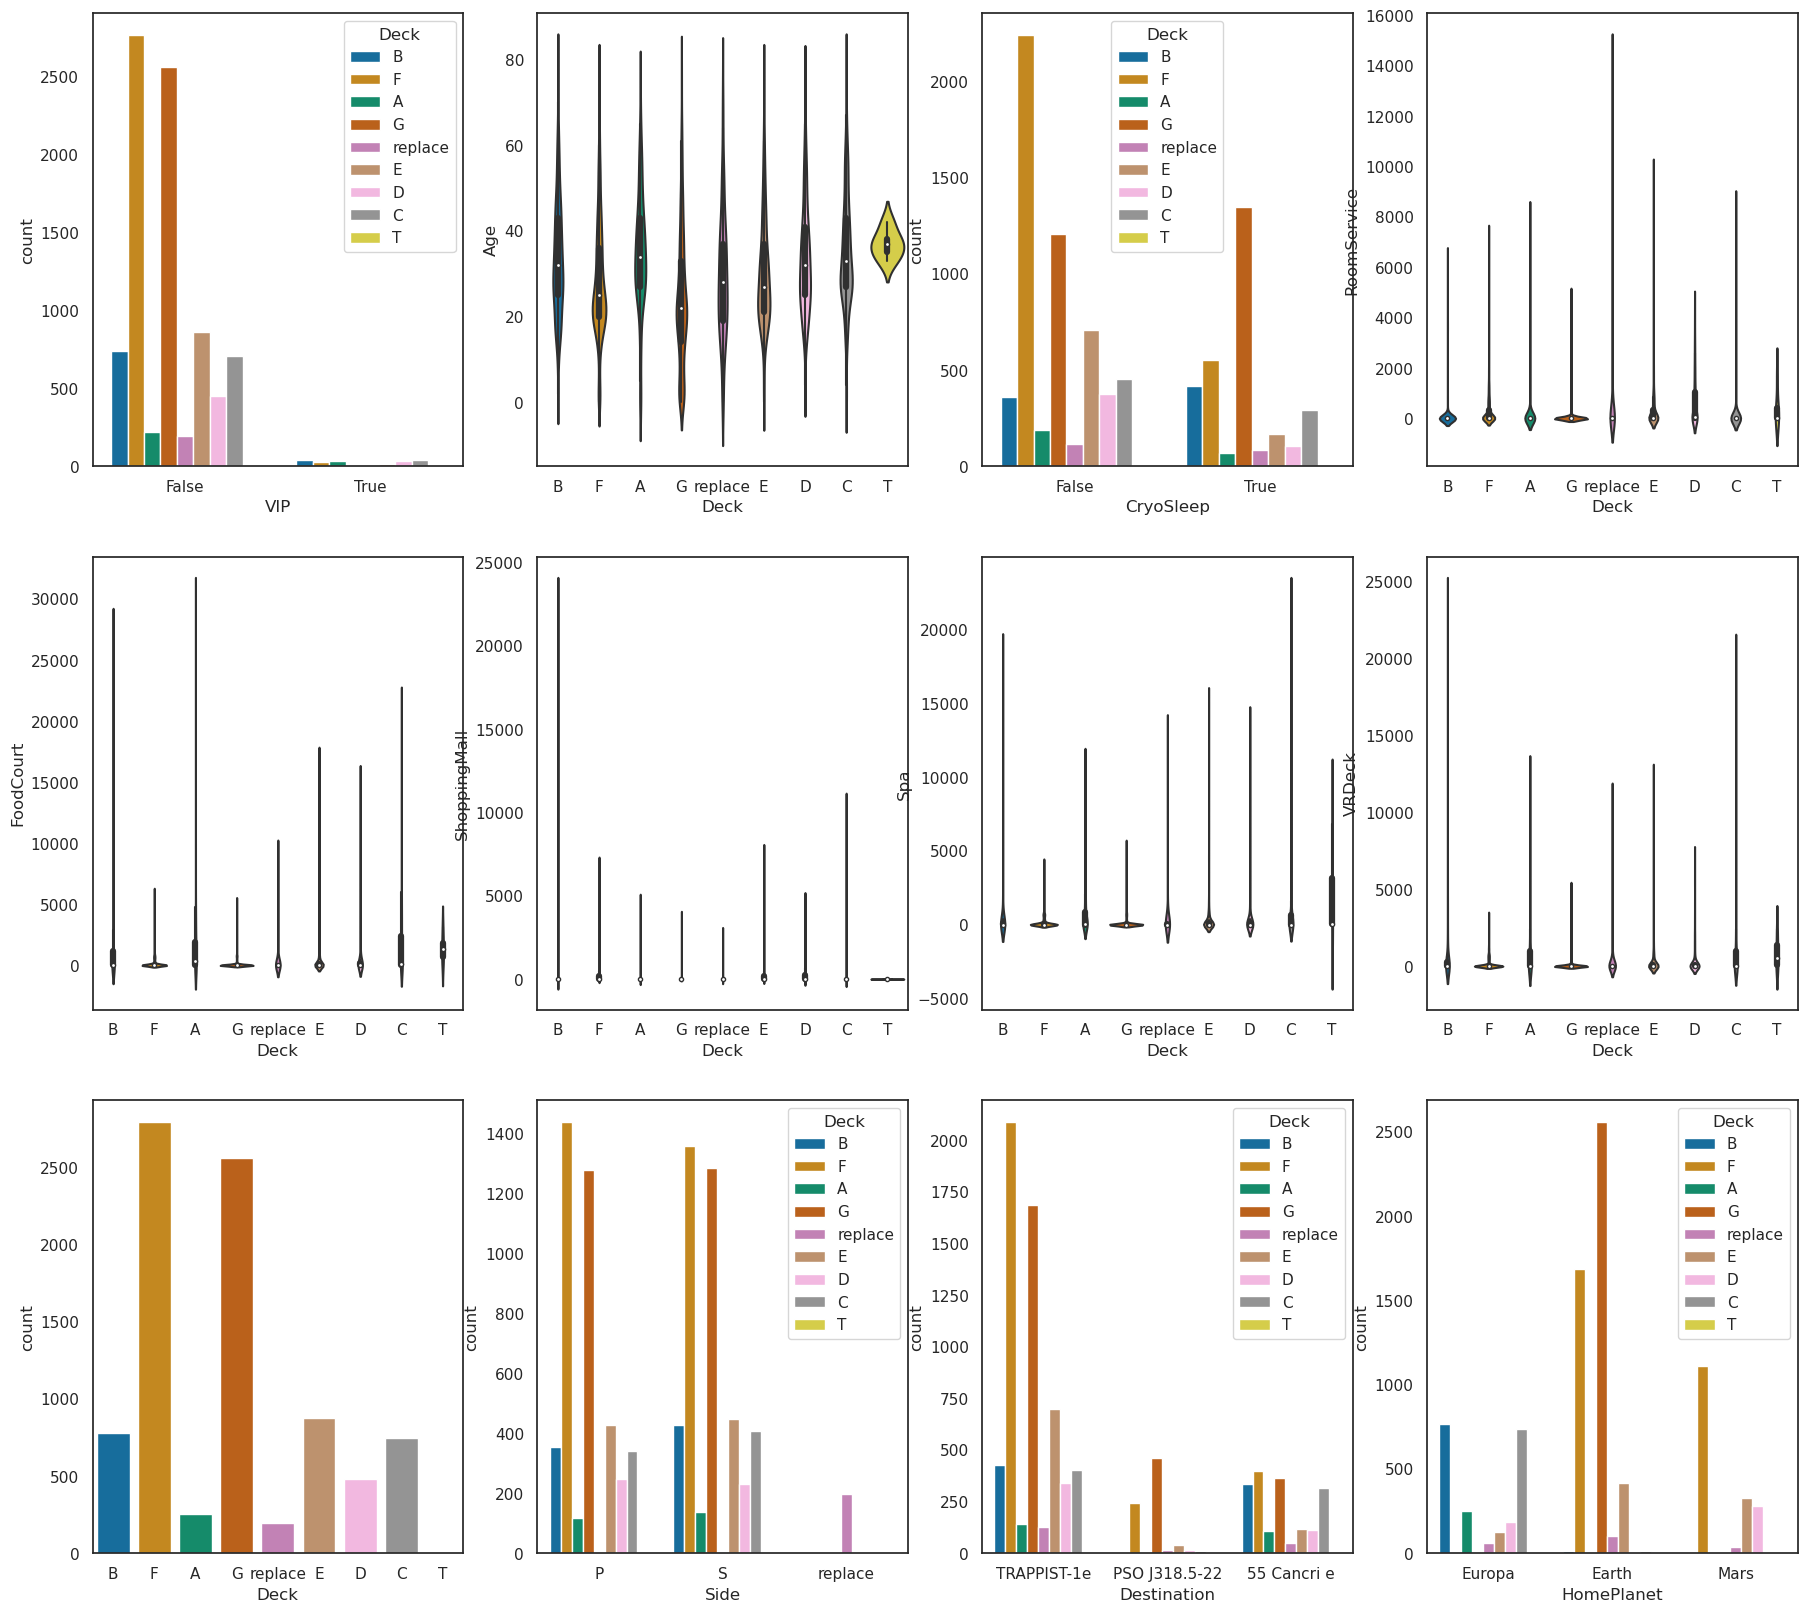

In [34]:
# categorical variable:  Deck
fig, axs = plt.subplots(3,4, figsize =(22, 20))
sns.countplot(data=train, x='VIP', hue='Deck', ax=axs[0,0])
sns.violinplot(train, x = 'Deck', y='Age', ax=axs[0,1])
sns.countplot(data=train, x='CryoSleep', hue='Deck', ax=axs[0,2])
sns.violinplot(train, x = 'Deck', y='RoomService', ax=axs[0,3])
sns.violinplot(train, x = 'Deck', y='FoodCourt', ax=axs[1,0])
sns.violinplot(train, x = 'Deck', y='ShoppingMall', ax=axs[1,1])
sns.violinplot(train, x = 'Deck', y='Spa', ax=axs[1,2])
sns.violinplot(train, x = 'Deck', y='VRDeck', ax=axs[1,3])
sns.countplot(data=train, x='Deck', ax=axs[2,0])
sns.countplot(data=train, x='Side', hue='Deck', ax=axs[2,1])
sns.countplot(data=train, x='Destination', hue='Deck', ax=axs[2,2])
sns.countplot(data=train, x='HomePlanet', hue='Deck', ax=axs[2,3])

* If ShoppingMall > 13000 then Deck 'replace' is Deck B. 
* All Deck 'replace will go to the most frequent, F.

In [35]:
condition7a = train['Deck'].str.contains('replace') & (train['ShoppingMall'] > 13000)
choice7a = train['Deck'].replace({'replace': 'B'})
train['Deck'] = np.select([condition7a], [choice7a], default=train['Deck'].replace({'replace':'F'}))
                          
condition7b = predict['Deck'].str.contains('replace') & (predict['ShoppingMall'] > 13000)
choice7b = predict['Deck'].replace({'replace': 'B'})
predict['Deck'] = np.select([condition7b], [choice7b], default=predict['Deck'].replace({'replace':'F'}))

**The next feature to look at is Side**
* Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.

<AxesSubplot:xlabel='HomePlanet', ylabel='count'>

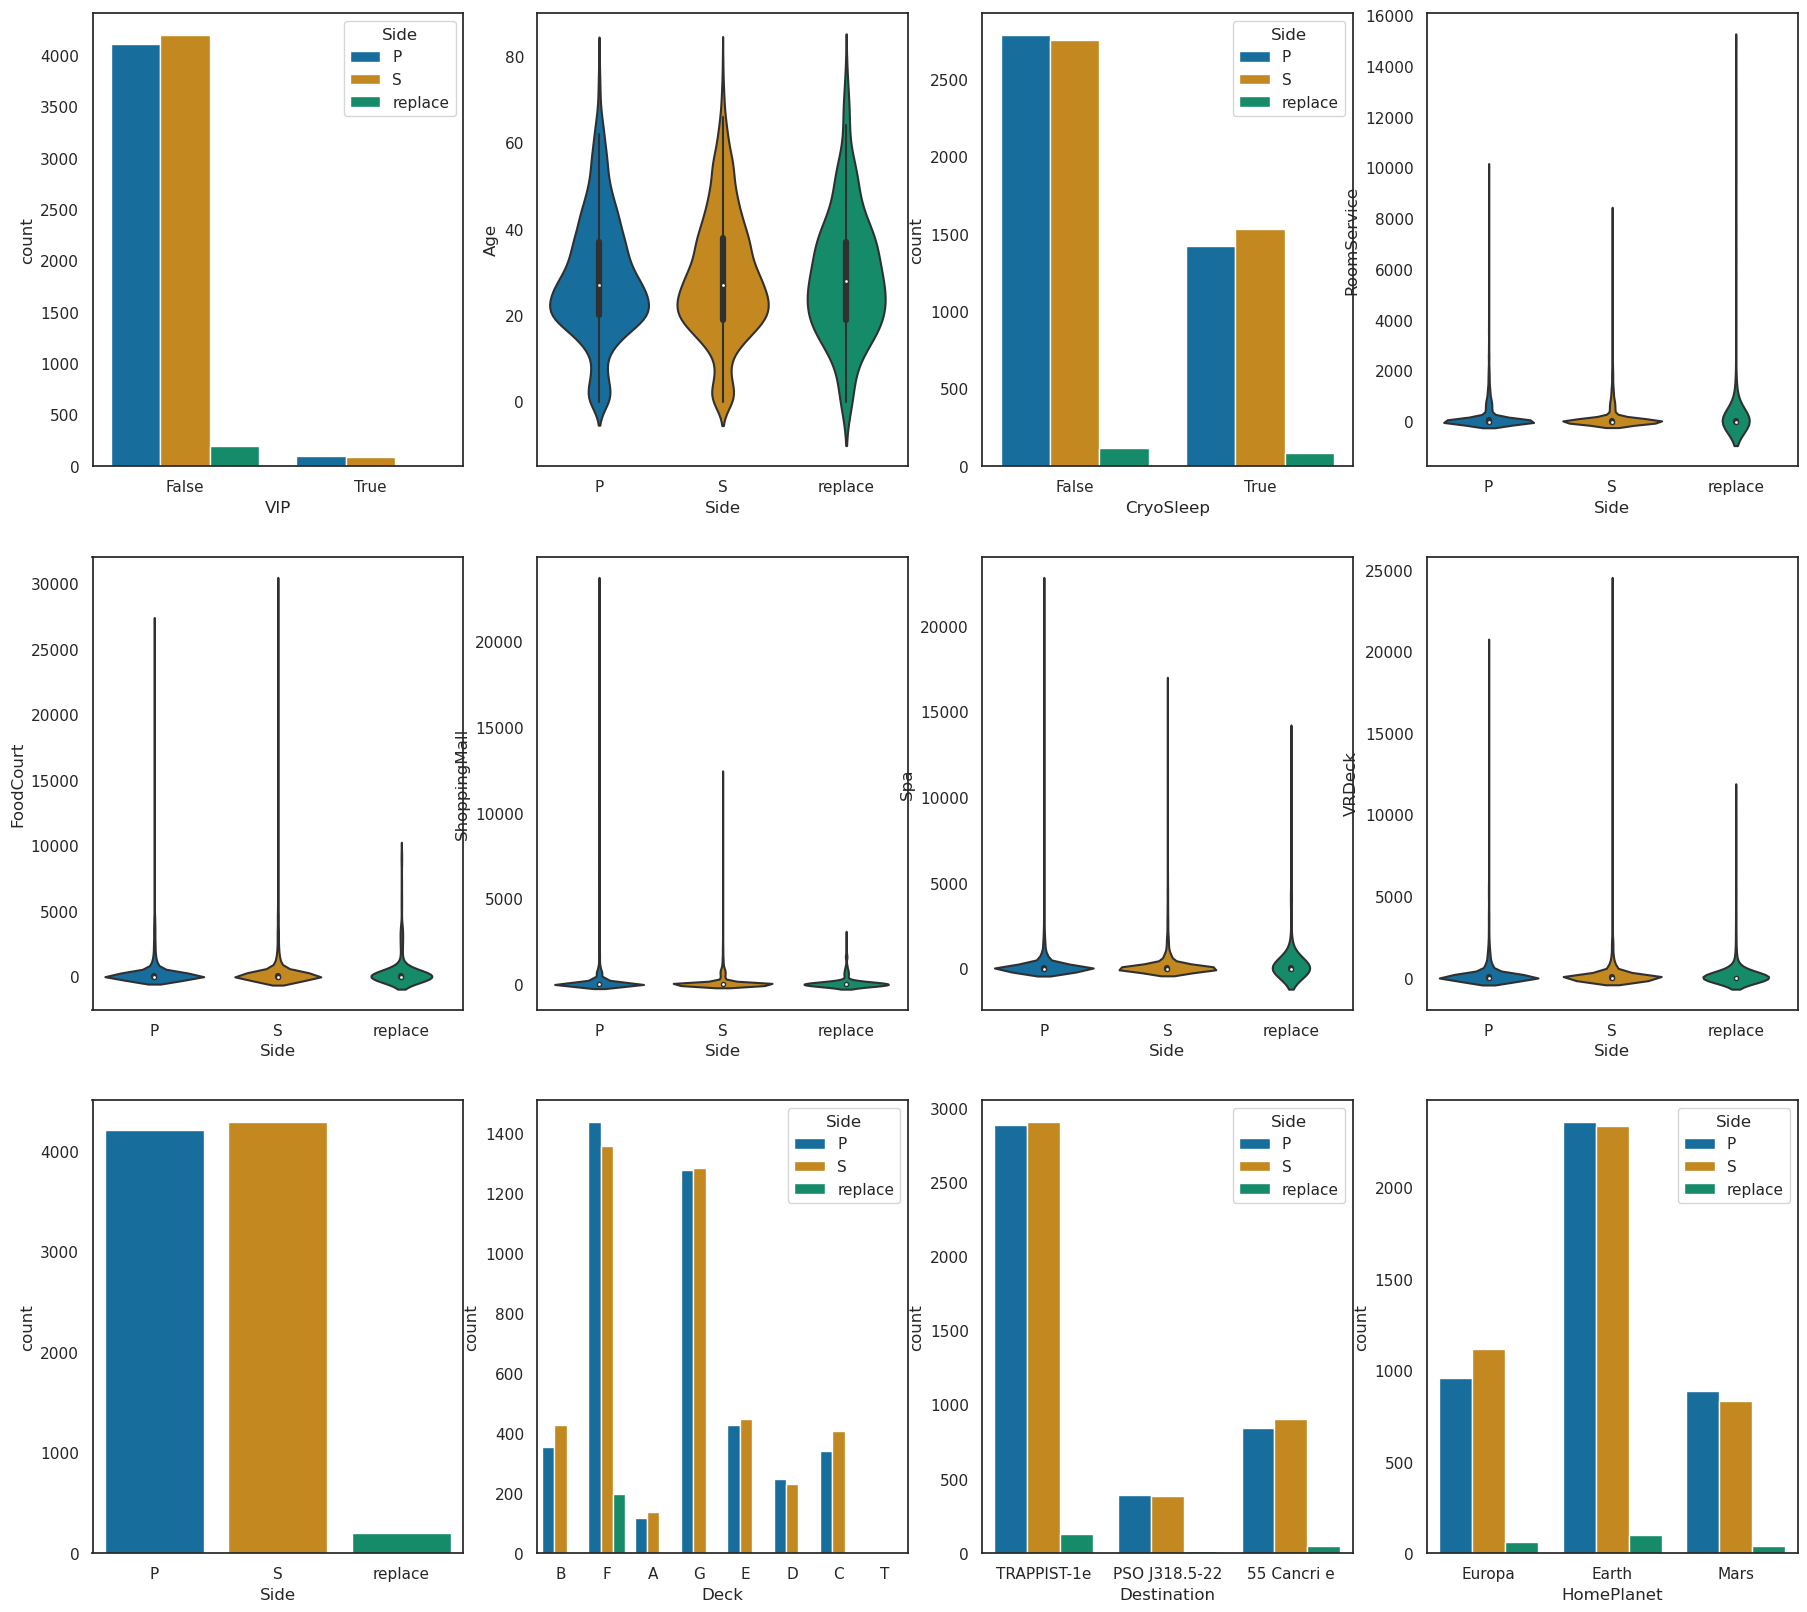

In [36]:
# categorical variable:  Side
fig, axs = plt.subplots(3,4, figsize =(22, 20))
sns.countplot(data=train, x='VIP', hue='Side', ax=axs[0,0])
sns.violinplot(train, x = 'Side', y='Age', ax=axs[0,1])
sns.countplot(data=train, x='CryoSleep', hue='Side', ax=axs[0,2])
sns.violinplot(train, x = 'Side', y='RoomService', ax=axs[0,3])
sns.violinplot(train, x = 'Side', y='FoodCourt', ax=axs[1,0])
sns.violinplot(train, x = 'Side', y='ShoppingMall', ax=axs[1,1])
sns.violinplot(train, x = 'Side', y='Spa', ax=axs[1,2])
sns.violinplot(train, x = 'Side', y='VRDeck', ax=axs[1,3])
sns.countplot(data=train, x='Side', ax=axs[2,0])
sns.countplot(data=train, x='Deck', hue='Side', ax=axs[2,1])
sns.countplot(data=train, x='Destination', hue='Side', ax=axs[2,2])
sns.countplot(data=train, x='HomePlanet', hue='Side', ax=axs[2,3])

* If ShoppingMall > 15000 then Side 'replace' should be P. 
* Otherwise I'll put in S as that is more frequent

In [37]:
condition8a = train['Side'].str.contains('replace') & (train['ShoppingMall'] > 15000)
choice8a = train['Side'].replace({'replace': 'P'})
train['Side'] = np.select([condition8a], [choice8a], default=train['Side'].replace({'replace':'S'}))
                          
condition8b = predict['Side'].str.contains('replace') & (predict['ShoppingMall'] > 15000)
choice8b = predict['Side'].replace({'replace': 'P'})
predict['Side'] = np.select([condition8b], [choice8b], default=predict['Side'].replace({'replace':'S'}))

**The next feature to look at is Num**
* Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
* I'll need to replace the 'replace' with Nan then convert the column to int64 before looking at it. 

In [38]:
train['Num'] = train['Num'].replace('replace', np.nan)
predict['Num'] = predict['Num'].replace('replace', np.nan)

In [39]:
train['Num'] = train['Num'].apply(pd.to_numeric, errors='ignore')
predict['Num'] = predict['Num'].apply(pd.to_numeric, errors='ignore')

In [40]:
train.head()

PassengerId HomePlanet  CryoSleep  Destination   Age    VIP  RoomService  \
0     0001_01     Europa      False  TRAPPIST-1e  39.0  False          0.0   
1     0002_01      Earth      False  TRAPPIST-1e  24.0  False        109.0   
2     0003_01     Europa      False  TRAPPIST-1e  58.0   True         43.0   
3     0003_02     Europa      False  TRAPPIST-1e  33.0  False          0.0   
4     0004_01      Earth      False  TRAPPIST-1e  16.0  False        303.0   

   FoodCourt  ShoppingMall     Spa  VRDeck  Transported Deck  Num Side  
0        0.0           0.0     0.0     0.0        False    B  0.0    P  
1        9.0          25.0   549.0    44.0         True    F  0.0    S  
2     3576.0           0.0  6715.0    49.0        False    A  0.0    S  
3     1283.0         371.0  3329.0   193.0        False    A  0.0    S  
4       70.0         151.0   565.0     2.0         True    F  1.0    S

<AxesSubplot:xlabel='HomePlanet', ylabel='Num'>

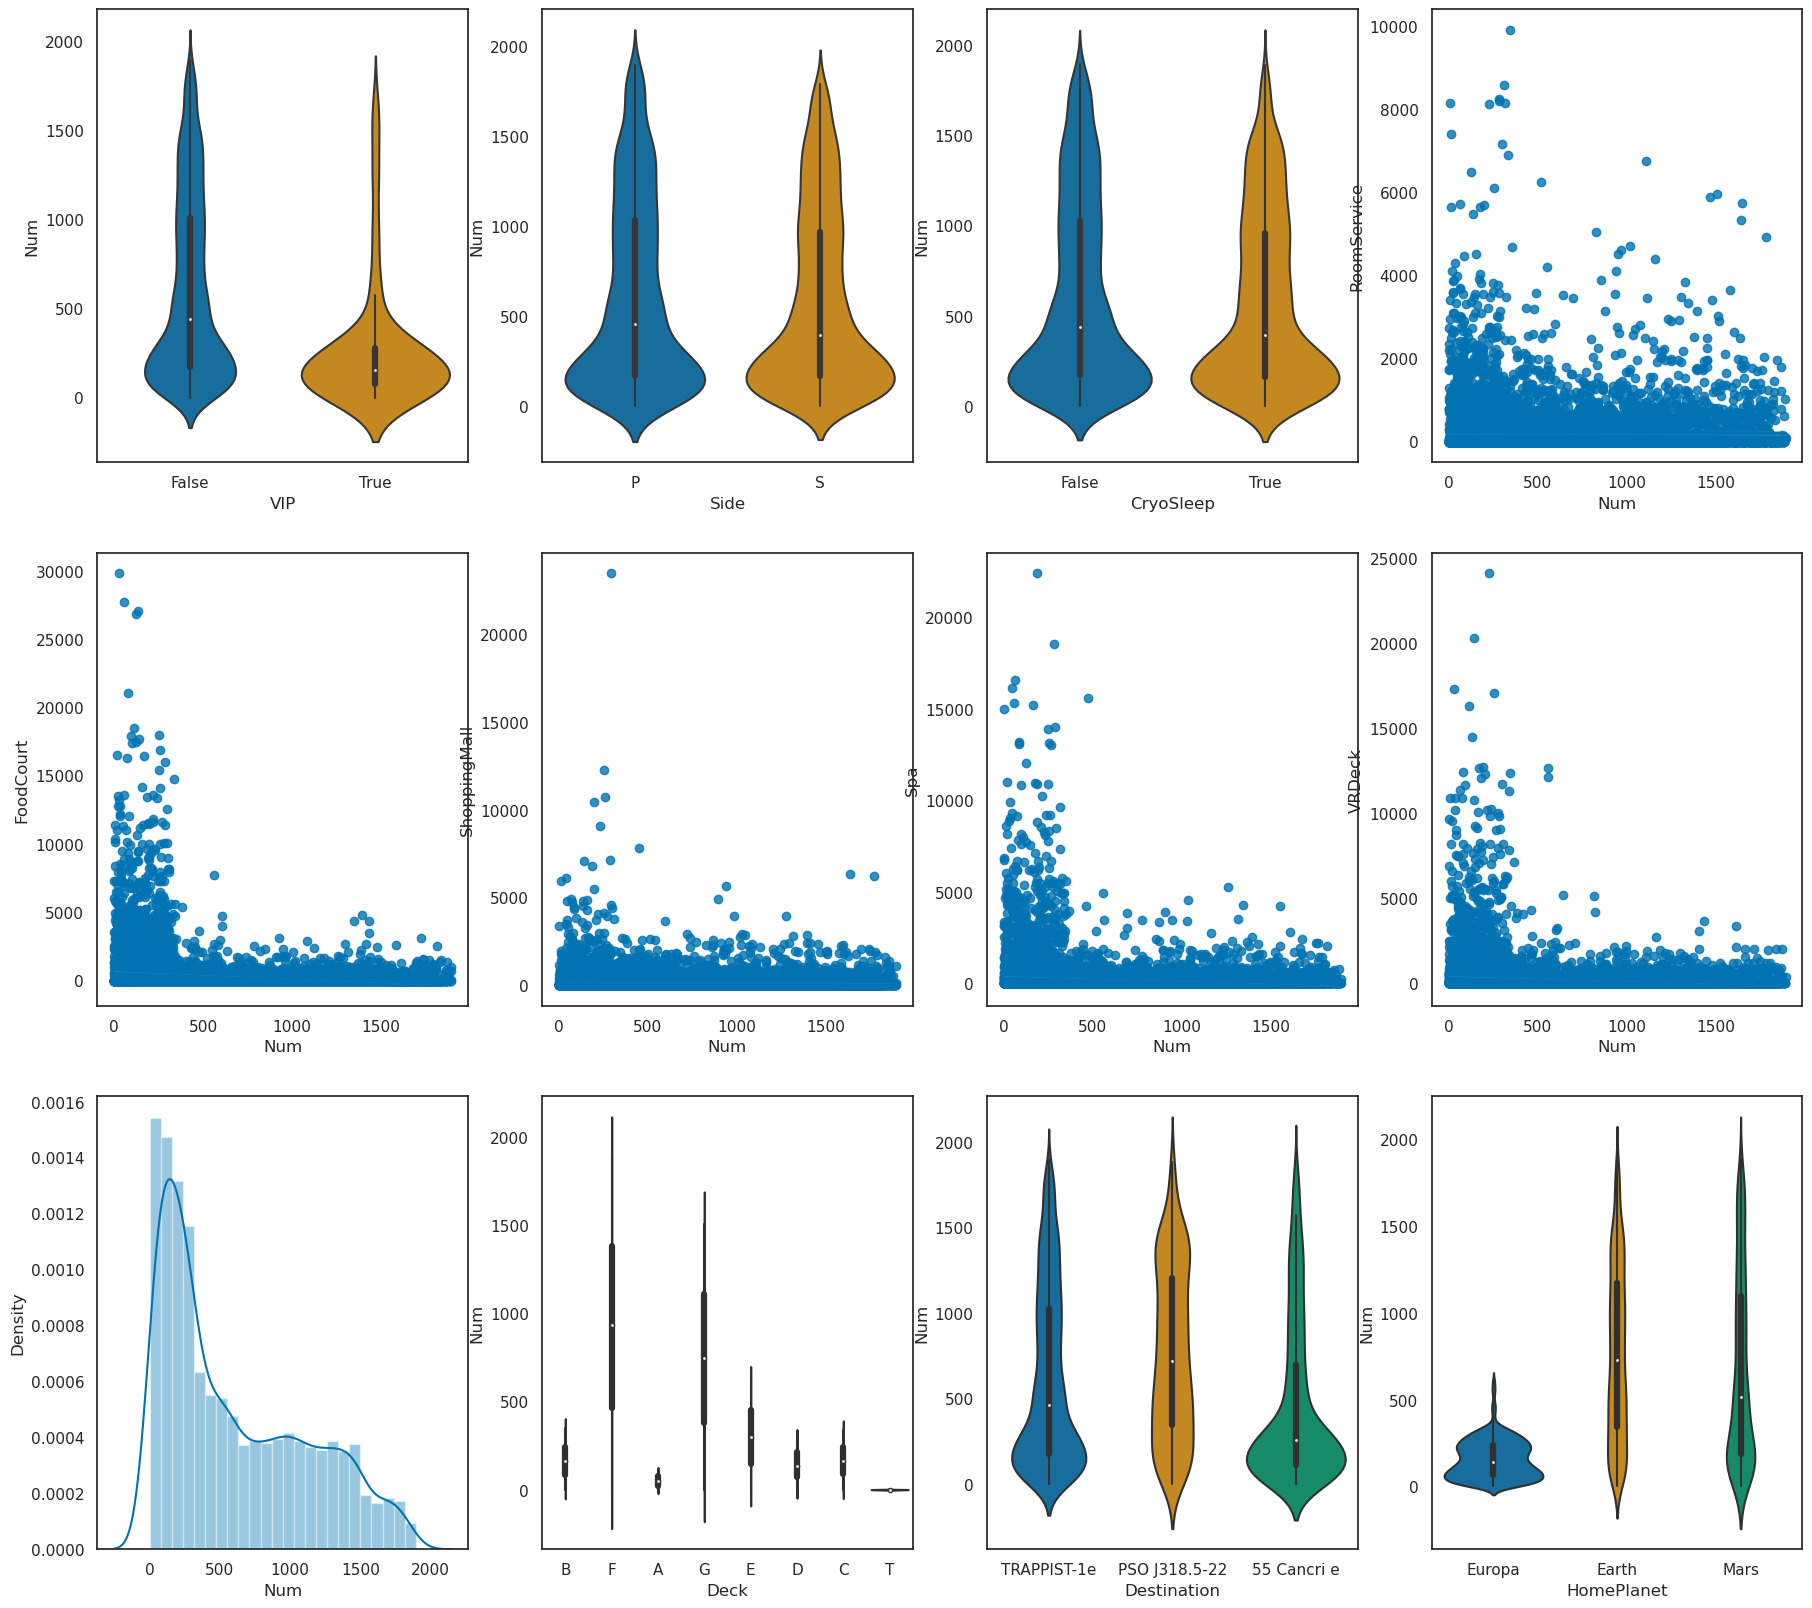

In [41]:
# Continuous variable:  Num
fig, axs = plt.subplots(3,4, figsize =(22, 20))
sns.violinplot(data=train, x='VIP', y='Num', ax=axs[0,0])
sns.violinplot(train, x = 'Side', y='Num', ax=axs[0,1])
sns.violinplot(data=train, x='CryoSleep', y='Num', ax=axs[0,2])
sns.regplot(train, x = 'Num', y='RoomService', ax=axs[0,3])
sns.regplot(train, x = 'Num', y='FoodCourt', ax=axs[1,0])
sns.regplot(train, x = 'Num', y='ShoppingMall', ax=axs[1,1])
sns.regplot(train, x = 'Num', y='Spa', ax=axs[1,2])
sns.regplot(train, x = 'Num', y='VRDeck', ax=axs[1,3])
sns.distplot(train['Num'], ax=axs[2,0])
sns.violinplot(data=train, x='Deck', y='Num', ax=axs[2,1])
sns.violinplot(data=train, x='Destination', y='Num', ax=axs[2,2])
sns.violinplot(data=train, x='HomePlanet', y='Num', ax=axs[2,3])

* We'll just use the median

In [42]:
train['Num'] = train['Num'].fillna(value=train['Num'].median())
predict['Num'] = predict['Num'].fillna(value=predict['Num'].median())
train.head()

PassengerId HomePlanet  CryoSleep  Destination   Age    VIP  RoomService  \
0     0001_01     Europa      False  TRAPPIST-1e  39.0  False          0.0   
1     0002_01      Earth      False  TRAPPIST-1e  24.0  False        109.0   
2     0003_01     Europa      False  TRAPPIST-1e  58.0   True         43.0   
3     0003_02     Europa      False  TRAPPIST-1e  33.0  False          0.0   
4     0004_01      Earth      False  TRAPPIST-1e  16.0  False        303.0   

   FoodCourt  ShoppingMall     Spa  VRDeck  Transported Deck  Num Side  
0        0.0           0.0     0.0     0.0        False    B  0.0    P  
1        9.0          25.0   549.0    44.0         True    F  0.0    S  
2     3576.0           0.0  6715.0    49.0        False    A  0.0    S  
3     1283.0         371.0  3329.0   193.0        False    A  0.0    S  
4       70.0         151.0   565.0     2.0         True    F  1.0    S

In [43]:
missing_vals_train = pd.DataFrame(train.isna().sum(), columns=['Sum'])
missing_vals_train = missing_vals_train.sort_values(by = 'Sum', ascending=False)
missing_vals_train = missing_vals_train[missing_vals_train['Sum']>0]
missing_vals_train['Percent'] = missing_vals_train['Sum']/8693*100
missing_vals_train

Sum   Percent
Destination  182  2.093639
Age          179  2.059128

**The next feature to look at is Destination**
*  Destination - The planet the passenger will be debarking to.

<AxesSubplot:xlabel='HomePlanet', ylabel='count'>

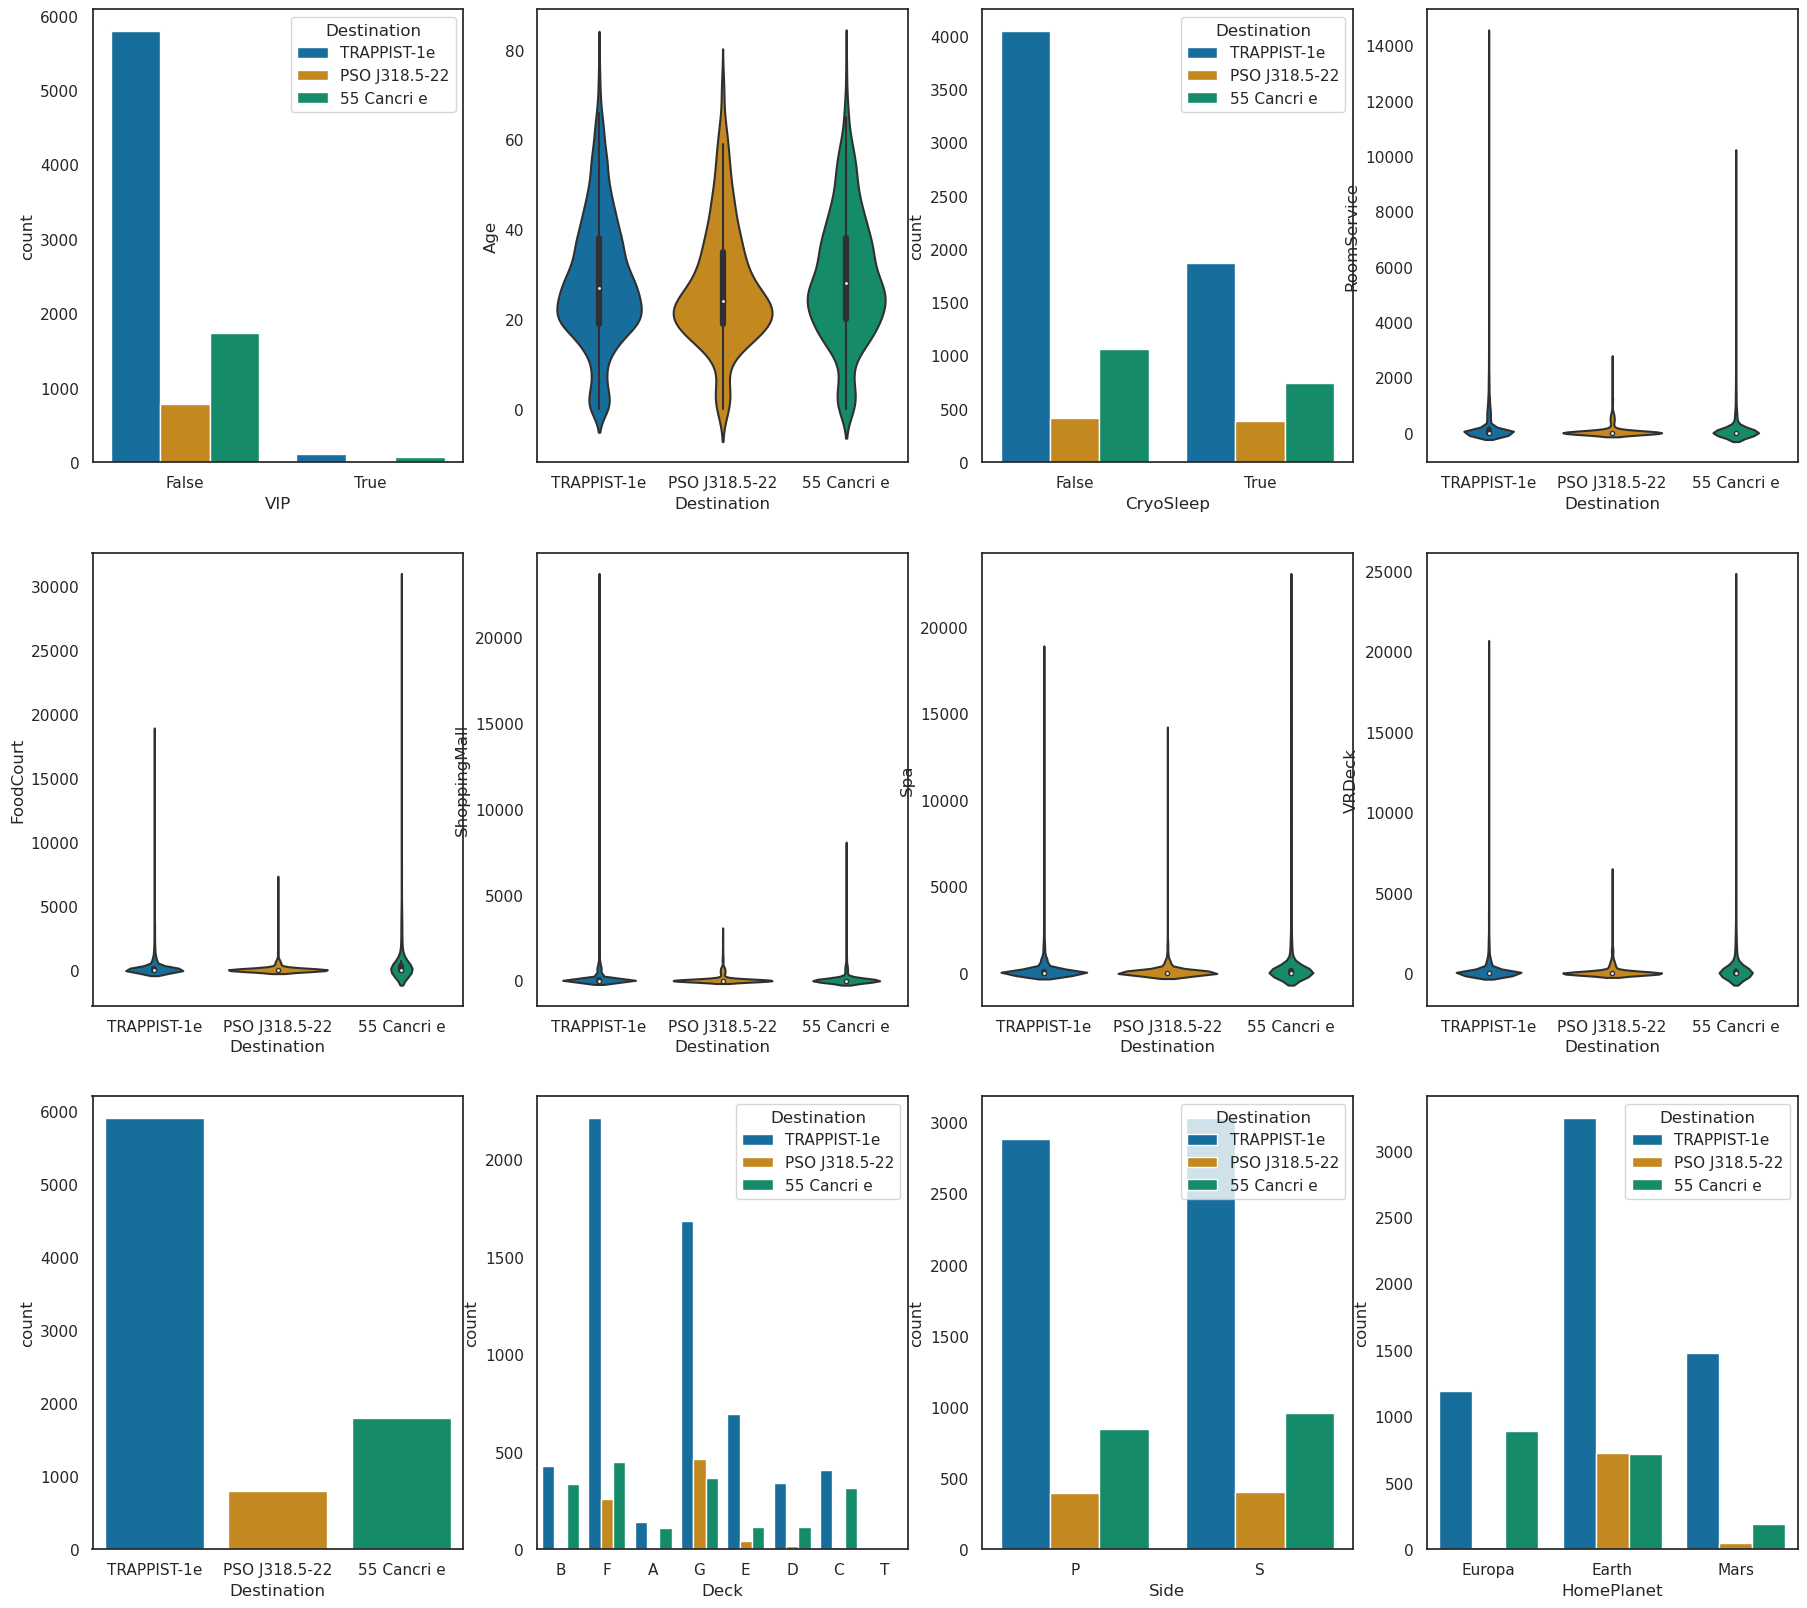

In [44]:
# categorical variable:  Destination
fig, axs = plt.subplots(3,4, figsize =(22, 20))
sns.countplot(data=train, x='VIP', hue='Destination', ax=axs[0,0])
sns.violinplot(train, x = 'Destination', y='Age', ax=axs[0,1])
sns.countplot(data=train, x='CryoSleep', hue='Destination', ax=axs[0,2])
sns.violinplot(train, x = 'Destination', y='RoomService', ax=axs[0,3])
sns.violinplot(train, x = 'Destination', y='FoodCourt', ax=axs[1,0])
sns.violinplot(train, x = 'Destination', y='ShoppingMall', ax=axs[1,1])
sns.violinplot(train, x = 'Destination', y='Spa', ax=axs[1,2])
sns.violinplot(train, x = 'Destination', y='VRDeck', ax=axs[1,3])
sns.countplot(data=train, x='Destination', ax=axs[2,0])
sns.countplot(data=train, x='Deck', hue='Destination', ax=axs[2,1])
sns.countplot(data=train, x='Side', hue='Destination', ax=axs[2,2])
sns.countplot(data=train, x='HomePlanet', hue='Destination', ax=axs[2,3])

* There is no condition where TRAPPIST-1 shouldn't be selected as most frequent

In [45]:
train['Destination'] = train['Destination'].fillna('TRAPPIST-1e')
predict['Destination'] = predict['Destination'].fillna('TRAPPIST-1e')

In [46]:
train['Destination'].value_counts()

TRAPPIST-1e      6097
55 Cancri e      1800
PSO J318.5-22     796
Name: Destination, dtype: int64

**The next feature to look at is Age**
*  Age - The age of the passenger.

<AxesSubplot:xlabel='HomePlanet', ylabel='Age'>

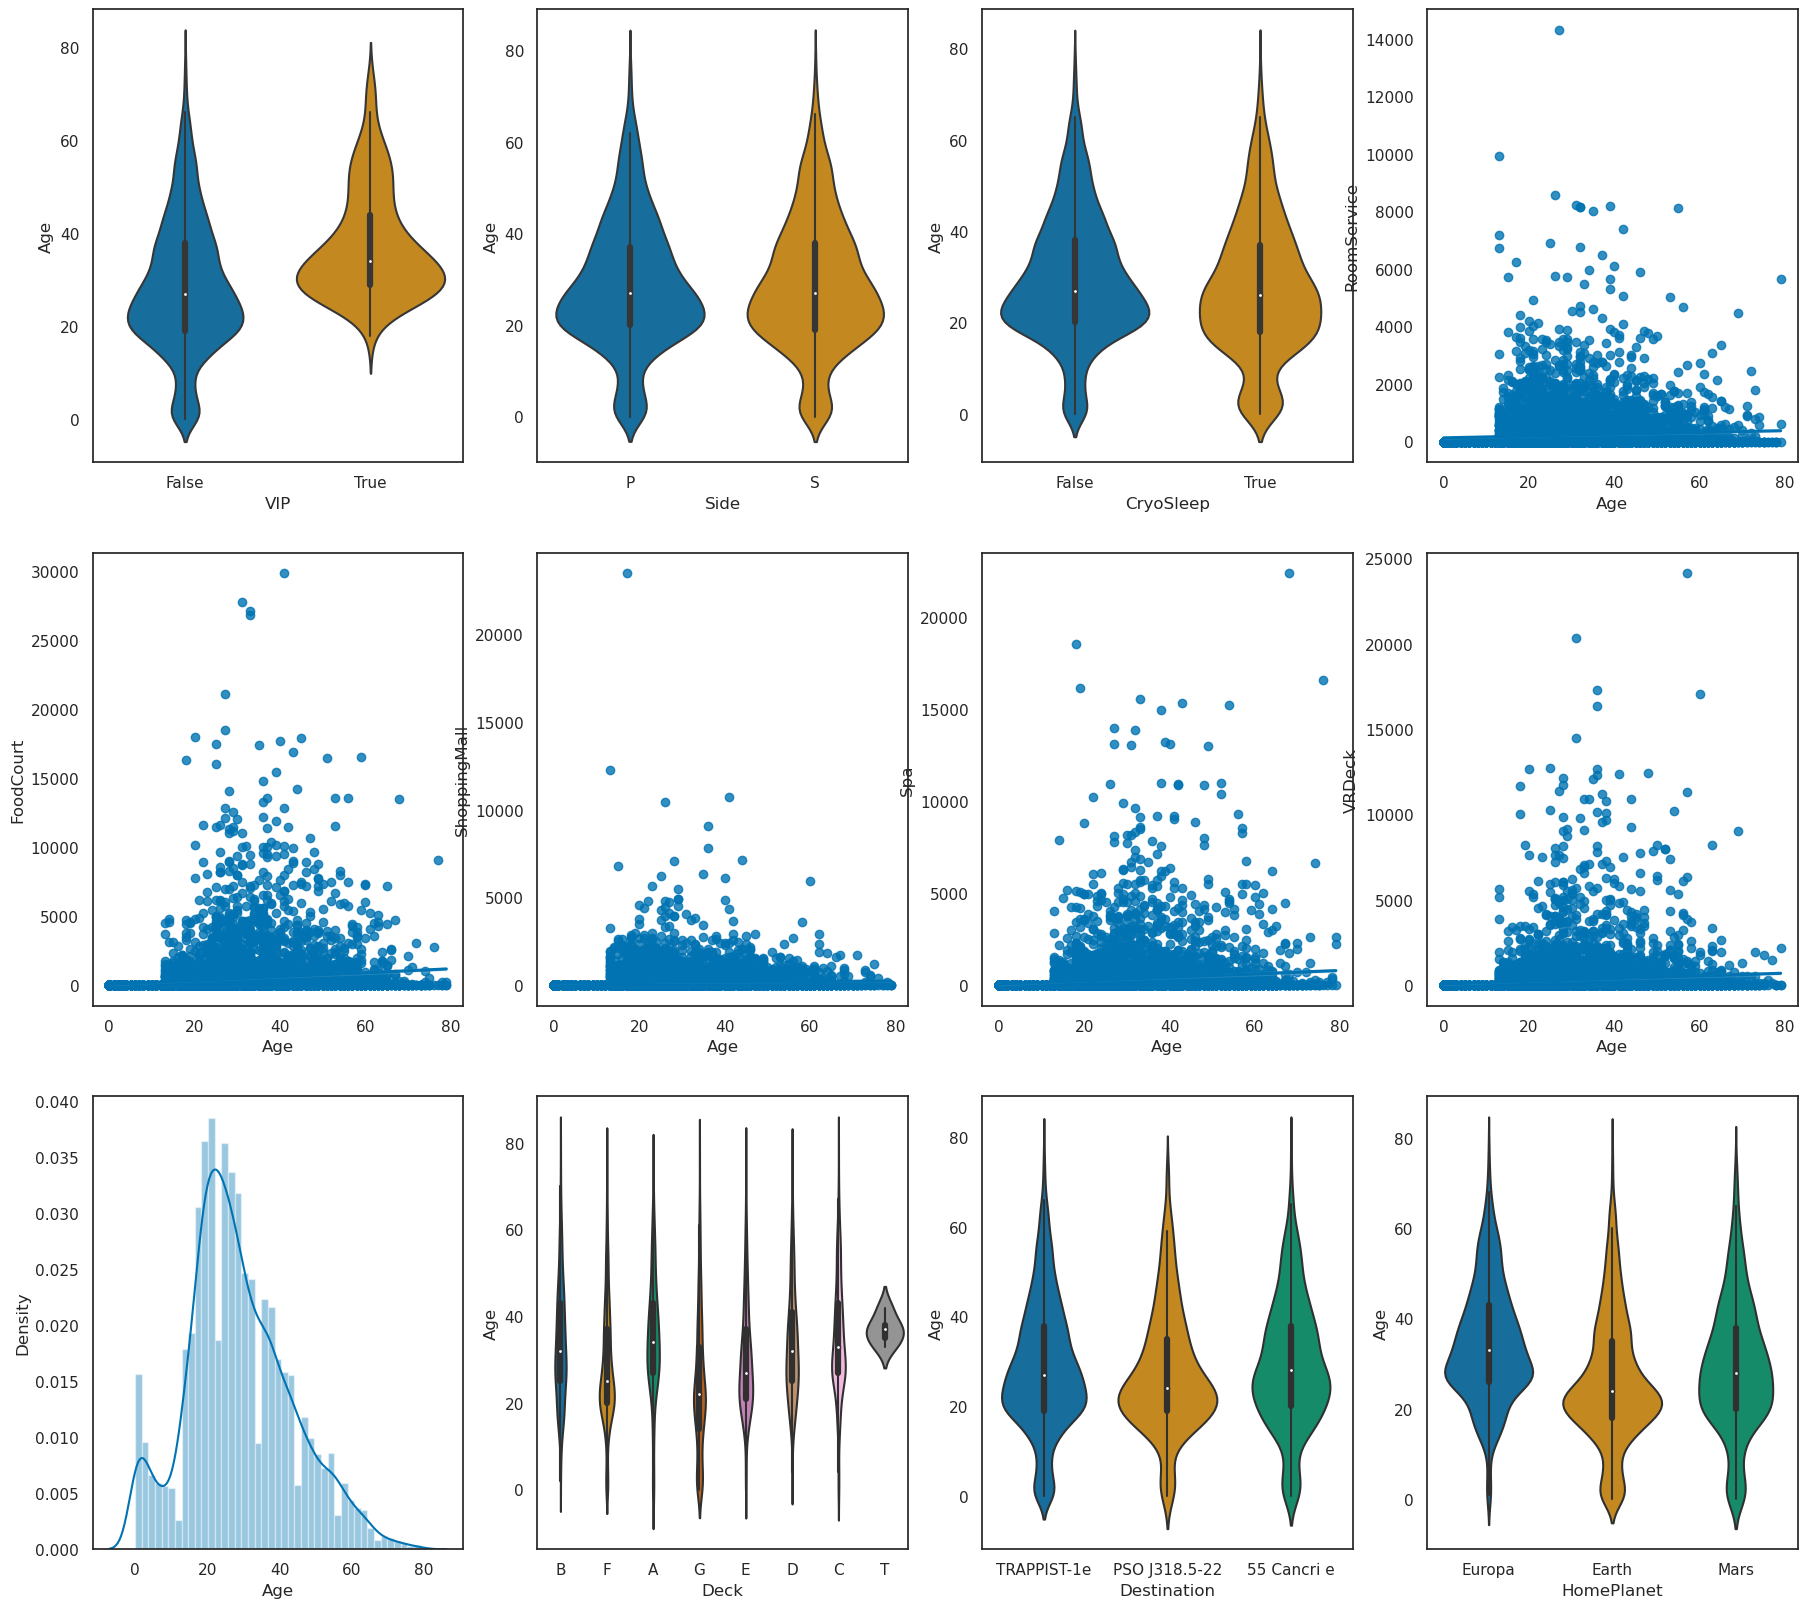

In [47]:
# Continuous variable:  Num
fig, axs = plt.subplots(3,4, figsize =(22, 20))
sns.violinplot(data=train, x='VIP', y='Age', ax=axs[0,0])
sns.violinplot(train, x = 'Side', y='Age', ax=axs[0,1])
sns.violinplot(data=train, x='CryoSleep', y='Age', ax=axs[0,2])
sns.regplot(train, x = 'Age', y='RoomService', ax=axs[0,3])
sns.regplot(train, x = 'Age', y='FoodCourt', ax=axs[1,0])
sns.regplot(train, x = 'Age', y='ShoppingMall', ax=axs[1,1])
sns.regplot(train, x = 'Age', y='Spa', ax=axs[1,2])
sns.regplot(train, x = 'Age', y='VRDeck', ax=axs[1,3])
sns.distplot(train['Age'], ax=axs[2,0])
sns.violinplot(data=train, x='Deck', y='Age', ax=axs[2,1])
sns.violinplot(data=train, x='Destination', y='Age', ax=axs[2,2])
sns.violinplot(data=train, x='HomePlanet', y='Age', ax=axs[2,3])

* Let's just go with the median

In [48]:
train['Age'] = train['Age'].fillna(value=train['Age'].median())
predict['Age'] = predict['Age'].fillna(value=predict['Age'].median())

In [49]:
missing_vals_predict = pd.DataFrame(predict.isna().sum(), columns=['Sum'])
missing_vals_predict = missing_vals_predict.sort_values(by = 'Sum', ascending=False)
missing_vals_predict = missing_vals_predict[missing_vals_predict['Sum']>0]
missing_vals_predict['Percent'] = missing_vals_predict['Sum']/8693*100
missing_vals_predict

Empty DataFrame
Columns: [Sum, Percent]
Index: []

# FINALLY! Let's go onto Feature Engineering
* Recall we saw some differences between younger and older! Let's look at Age
* Passenger ID may well contain useful features too!

**Let's do an intial coorelations table to see how we progress**

<AxesSubplot:>

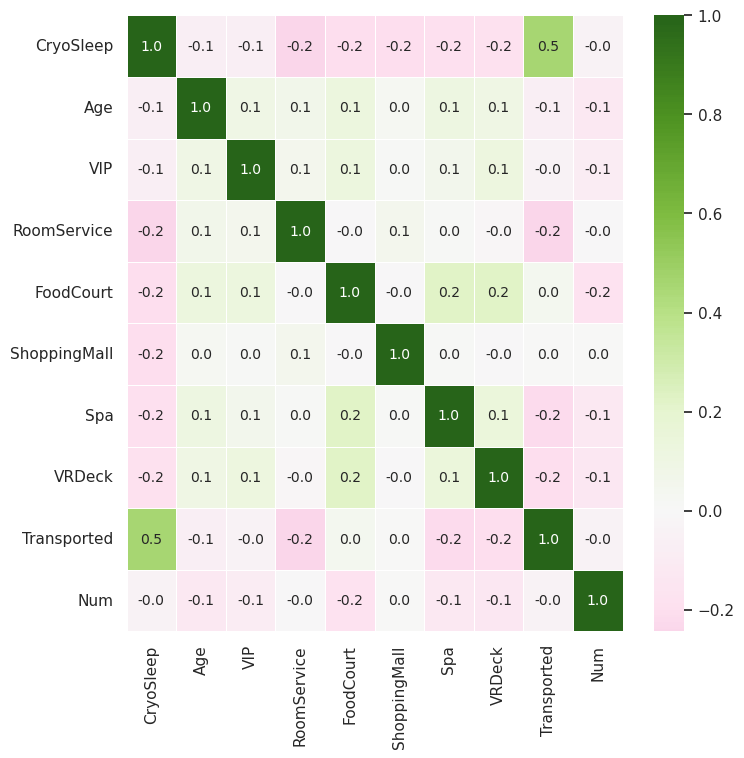

In [50]:
corr_matrix_1 = train.corr('pearson')
plt.subplots(figsize=(8, 8))
sns.heatmap(corr_matrix_1, cmap="PiYG", center=0, annot=True, linewidths=0.5, annot_kws={"size": 10}, fmt='.1f')

* Looks like a coorelation between CryoSleep and Transported
* Not a lot of other significant coorelations at present. 

**Let's start with Age**

<AxesSubplot:xlabel='Transported', ylabel='Age'>

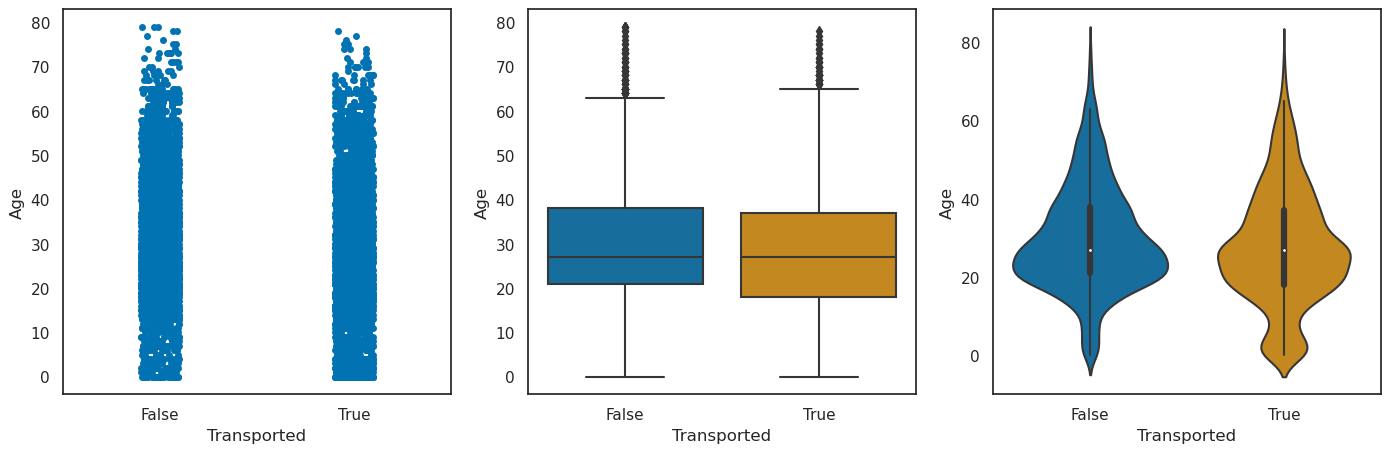

In [51]:
fig, ax = plt.subplots(1,3, figsize =(17, 5))
sns.stripplot(train, x = 'Transported', y='Age', ax=ax[0])
sns.boxplot(train, x = 'Transported', y='Age', ax=ax[1])
sns.violinplot(train, x = 'Transported', y='Age', ax=ax[2])

**It looks like you are more likely to be transported if you are under 10 years old**
* Let's create a new feature called Under10

In [52]:
#train['Under10'] = 0
#train.loc[train['Age'] < 10, 'Under10'] = 1

#predict['Under10'] = 0
#predict.loc[predict['Age'] < 10, 'Under10'] = 1

**Let's look into PassengerID**
* PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.


*** Let's create two new features. One for group and another for people.**
* We will need to create a function to separate group and people

In [53]:
# get split cabin
def get_Id(Id):
    step_1 = Id.split('_')
    group = step_1[0]
    people = step_1[1]
    
    return group, people

In [54]:
Ids_train = train['PassengerId']
groups_train = []
peoples_train = []
for Id_train in Ids_train:
    result_train = get_Id(Id_train)
    groups_train.append(result_train[0])
    peoples_train.append(result_train[1])
train['Group'] = groups_train
train['People'] = peoples_train

Ids_predict = predict['PassengerId']
groups_predict = []
peoples_predict = []
for Id_predict in Ids_predict:
    result_predict = get_Id(Id_predict)
    groups_predict.append(result_predict[0])
    peoples_predict.append(result_predict[1])
predict['Group'] = groups_predict
predict['People'] = peoples_predict


In [55]:
train['Group'] 

0       0001
1       0002
2       0003
3       0003
4       0004
        ... 
8688    9276
8689    9278
8690    9279
8691    9280
8692    9280
Name: Group, Length: 8693, dtype: object

In [56]:
train['Group'] = train['Group'].apply(pd.to_numeric, errors='ignore')

predict['Group'] = predict['Group'].apply(pd.to_numeric, errors='ignore')

<AxesSubplot:xlabel='Transported', ylabel='Group'>

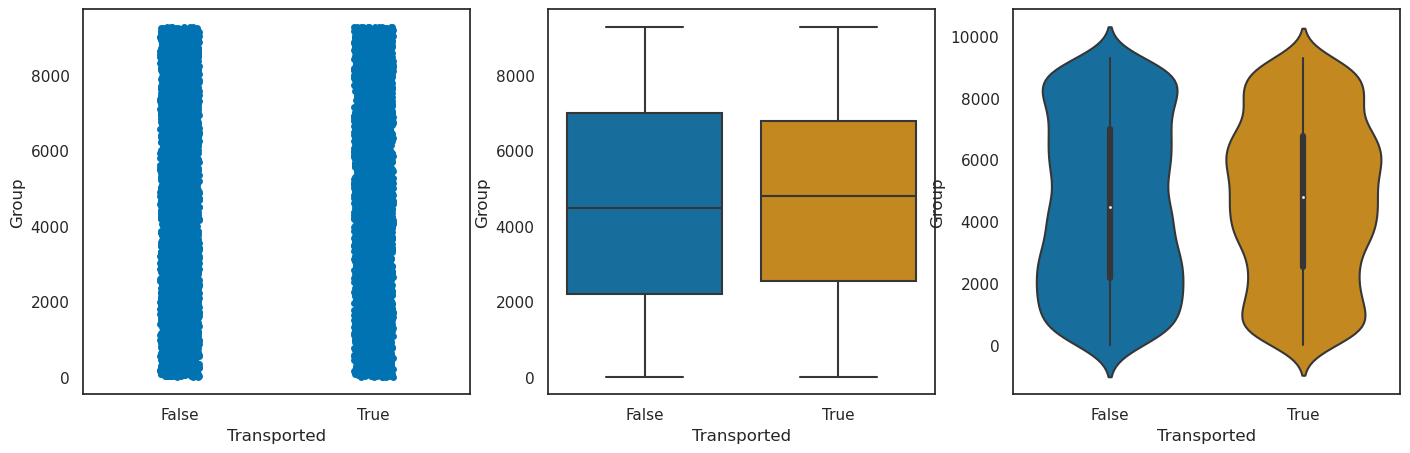

In [57]:
fig, ax = plt.subplots(1,3, figsize =(17, 5))
sns.stripplot(train, x = 'Transported', y='Group', ax=ax[0])
sns.boxplot(train, x = 'Transported', y='Group', ax=ax[1])
sns.violinplot(train, x = 'Transported', y='Group', ax=ax[2])

**Maybe a bit wider at the top for Transported False? Unsure if that could be claimed**

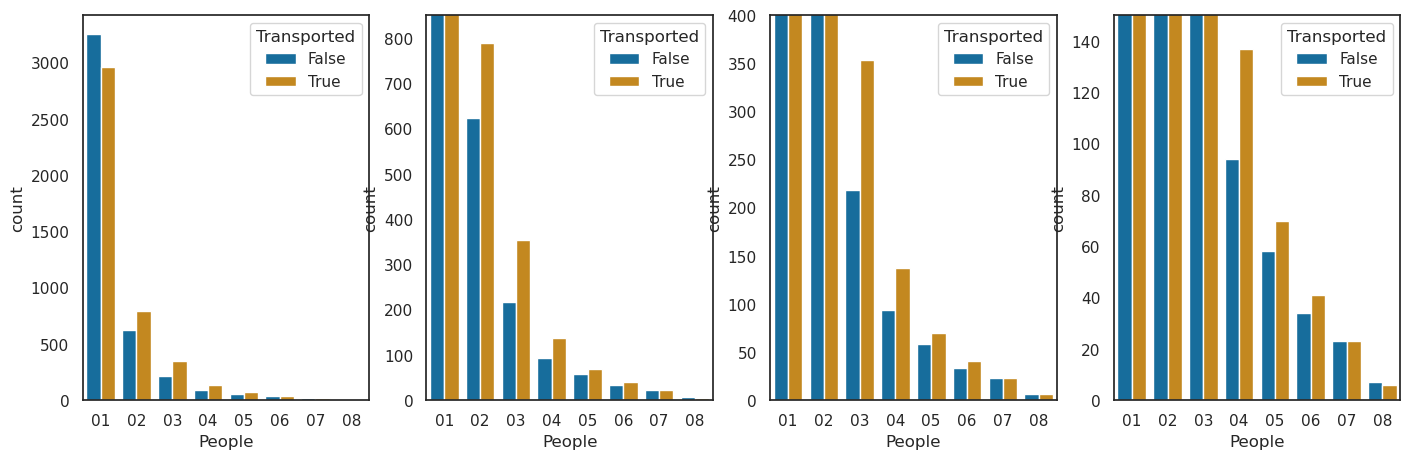

In [58]:
# categorical variable:  People
fig, ax = plt.subplots(1,4, figsize =(17, 5))
sns.countplot(data=train, x='People', hue='Transported', ax=ax[0])
sns.countplot(data=train, x='People', hue='Transported', ax=ax[1])
sns.countplot(data=train, x='People', hue='Transported', ax=ax[2])
sns.countplot(data=train, x='People', hue='Transported', ax=ax[3])
ax[1].set_ylim(0, 850)
ax[2].set_ylim(0, 400)
ax[3].set_ylim(0, 150)
plt.show()

**Suggest we create 4 new features from this: Individual, SmallFam, MediumFam, LargeFam**


In [59]:
#train['People'] = train['People'].apply(pd.to_numeric, errors='ignore')

#predict['People'] = predict['People'].apply(pd.to_numeric, errors='ignore')

In [60]:
#train['Individual'] = 0
#train.loc[train['People'] < 2, 'Individual'] = 1

#predict['Individual'] = 0
#predict.loc[predict['People'] < 2, 'Individual'] = 1

In [61]:
#train['SmallFam'] = 0
#train.loc[(train['People'] > 1) & (train['People'] < 5), 'SmallFam'] = 1

#predict['SmallFam'] = 0
#predict.loc[(predict['People'] > 1) & (predict['People'] < 5), 'SmallFam'] = 1

In [62]:
#train['MediumFam'] = 0
#train.loc[(train['People'] > 4) & (train['People'] < 7), 'MediumFam'] = 1

#predict['MediumFam'] = 0
#predict.loc[(predict['People'] > 4) & (predict['People'] < 7), 'MediumFam'] = 1

In [63]:
#train['LargeFam'] = 0
#train.loc[train['People'] > 6, 'LargeFam'] = 1

#predict['LargeFam'] = 0
#predict.loc[predict['People'] > 6, 'LargeFam'] = 1

In [64]:
#train = train.drop(['People'], axis=1)
#predict = predict.drop(['People'], axis=1)

**Let's convert our target variable from True/False to 1/0**
* While we are at it let's do the same for CryoSleep and VIP

In [65]:
train["Transported"] = train["Transported"].astype(int)

In [66]:
train["CryoSleep"] = train["CryoSleep"].astype(int)

predict["CryoSleep"] = predict["CryoSleep"].astype(int)

In [67]:
train["VIP"] = train["VIP"].astype(int)

predict["VIP"] = predict["VIP"].astype(int)

**Let's see if we have made any progress with coorelations!**

<AxesSubplot:>

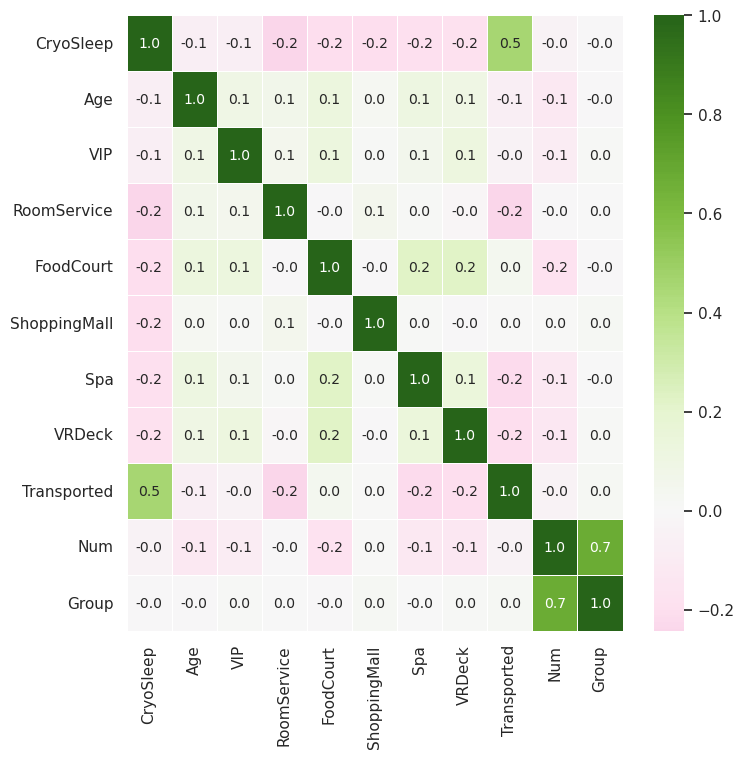

In [68]:
corr_matrix_2 = train.corr('pearson')
plt.subplots(figsize=(8, 8))
sns.heatmap(corr_matrix_2, cmap="PiYG", center=0, annot=True, linewidths=0.5, annot_kws={"size": 10}, fmt='.1f')

**Let's look into the continuous features related to cash**
* RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.

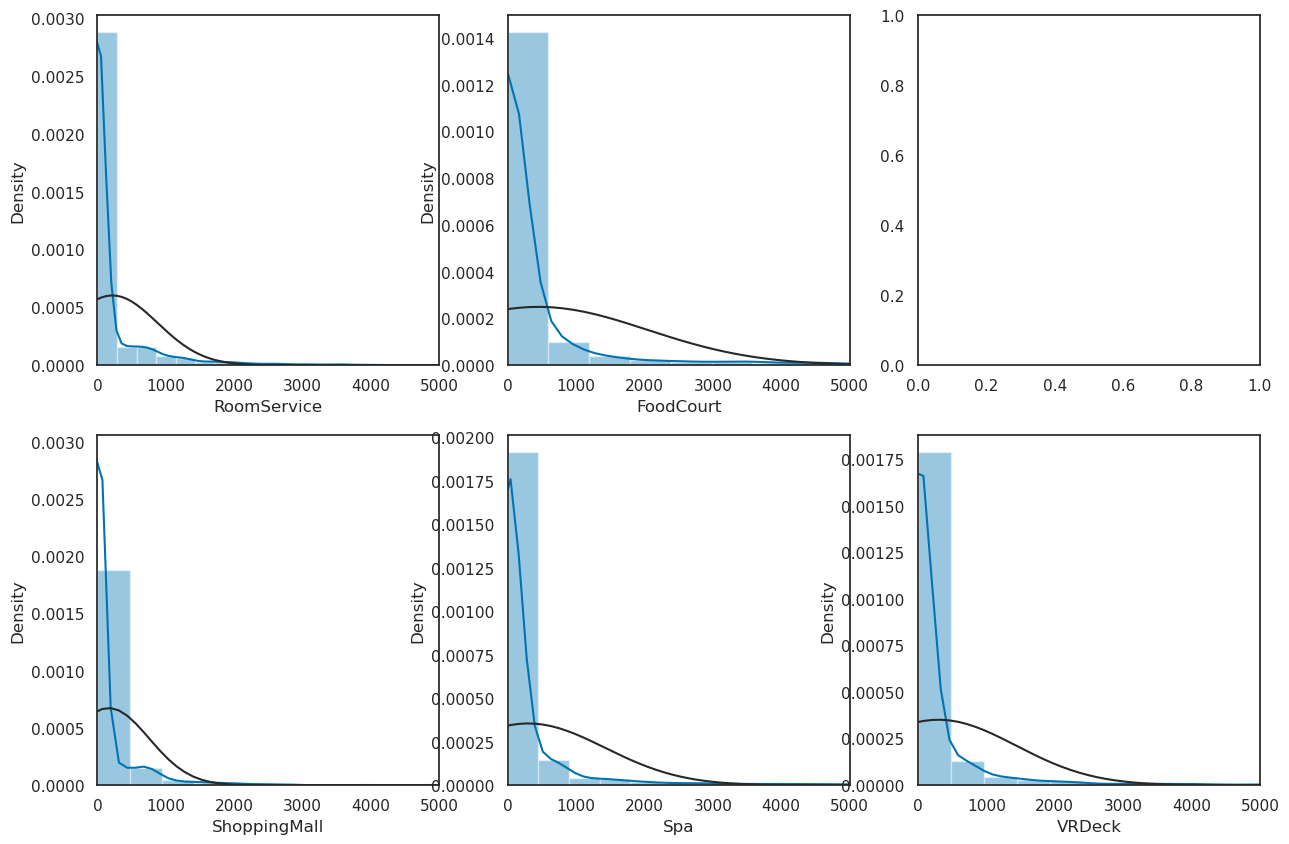

In [69]:
fig, axs = plt.subplots(2,3, figsize=(15, 10))
sns.distplot(train['RoomService'], fit=stats.norm, ax=axs[0,0])
sns.distplot(train['FoodCourt'], fit=stats.norm, ax=axs[0,1])
sns.distplot(train['ShoppingMall'], fit=stats.norm, ax=axs[1,0])
sns.distplot(train['Spa'], fit=stats.norm, ax=axs[1,1])
sns.distplot(train['VRDeck'], fit=stats.norm, ax=axs[1,2])
axs[0,0].set_xlim(0, 5000)
axs[0,1].set_xlim(0, 5000)
axs[1,0].set_xlim(0, 5000)
axs[1,1].set_xlim(0, 5000)
axs[1,2].set_xlim(0, 5000)
plt.show()

* Lot's of 0's which will need to be dealt with.
* Let's proceed with some visualisations to decide our approach. 

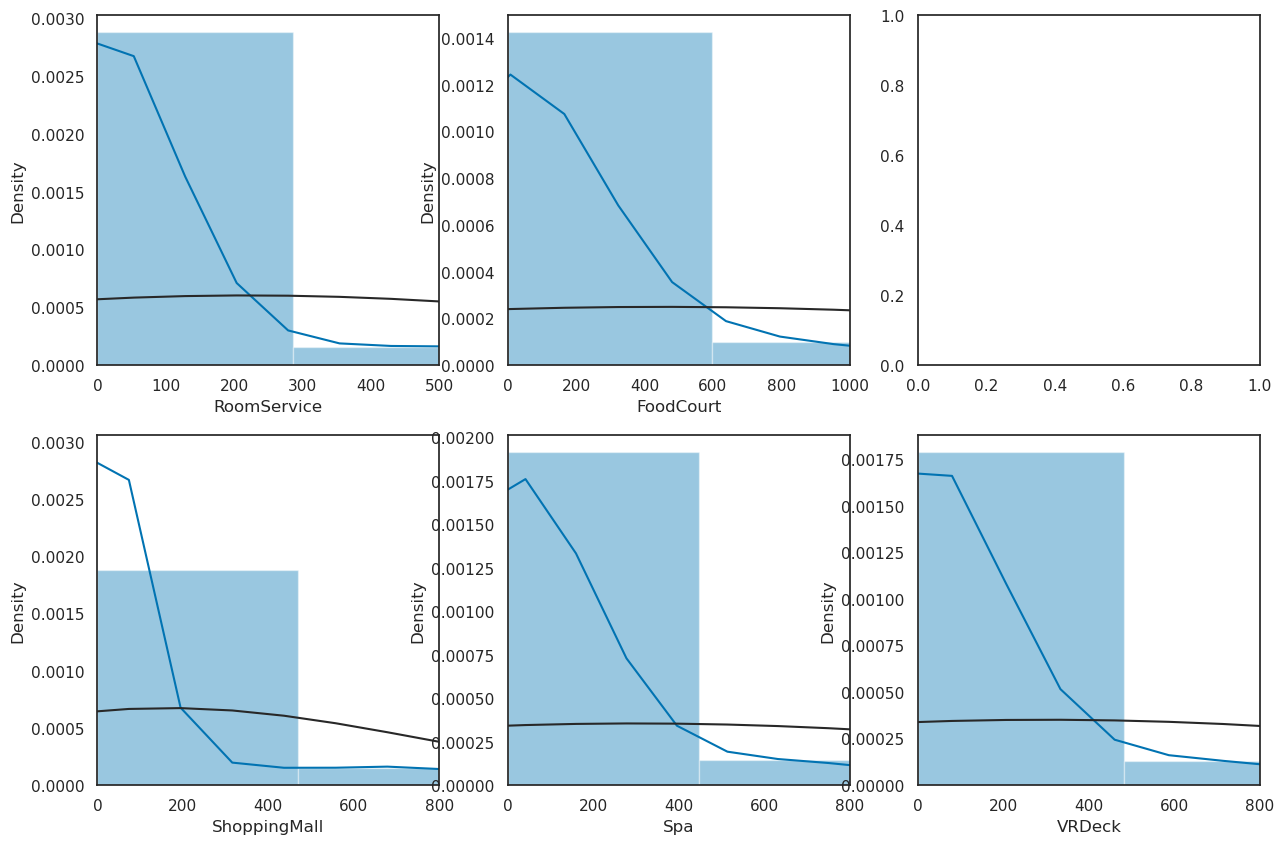

In [70]:
fig, axs = plt.subplots(2,3, figsize=(15, 10))
sns.distplot(train['RoomService'], fit=stats.norm, ax=axs[0,0])
sns.distplot(train['FoodCourt'], fit=stats.norm, ax=axs[0,1])
sns.distplot(train['ShoppingMall'], fit=stats.norm, ax=axs[1,0])
sns.distplot(train['Spa'], fit=stats.norm, ax=axs[1,1])
sns.distplot(train['VRDeck'], fit=stats.norm, ax=axs[1,2])
axs[0,0].set_xlim(0, 500)
axs[0,1].set_xlim(0, 1000)
axs[1,0].set_xlim(0, 800)
axs[1,1].set_xlim(0, 800)
axs[1,2].set_xlim(0, 800)
plt.show()

* Most of the data is below a cost of 400-600 with the vast majority as a 0. 

<AxesSubplot:xlabel='Transported', ylabel='VRDeck'>

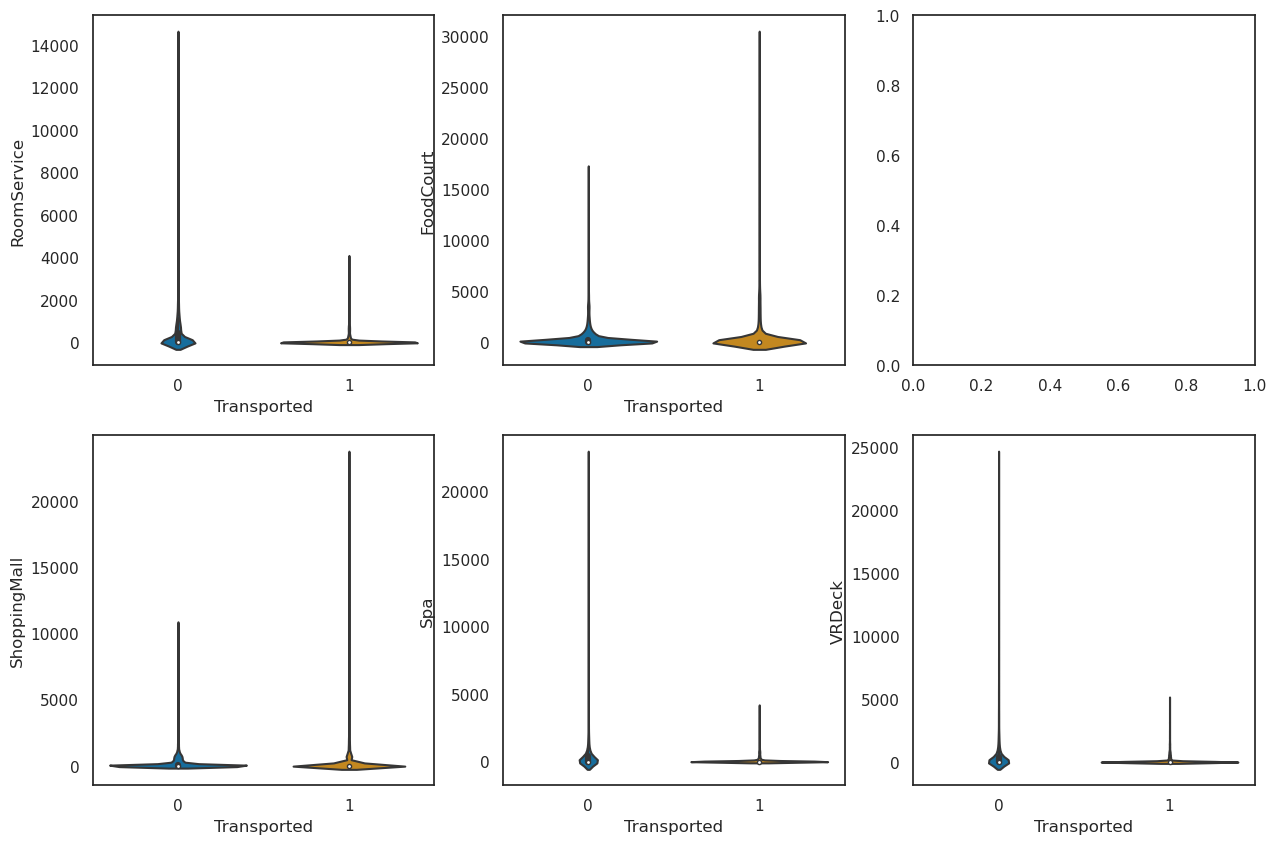

In [71]:
fig, axs = plt.subplots(2,3, figsize=(15, 10))
sns.violinplot(train, x='Transported', y='RoomService', ax=axs[0,0])
sns.violinplot(train, x='Transported', y='FoodCourt', ax=axs[0,1])
sns.violinplot(train, x='Transported', y='ShoppingMall', ax=axs[1,0])
sns.violinplot(train, x='Transported', y='Spa', ax=axs[1,1])
sns.violinplot(train, x='Transported', y='VRDeck', ax=axs[1,2])

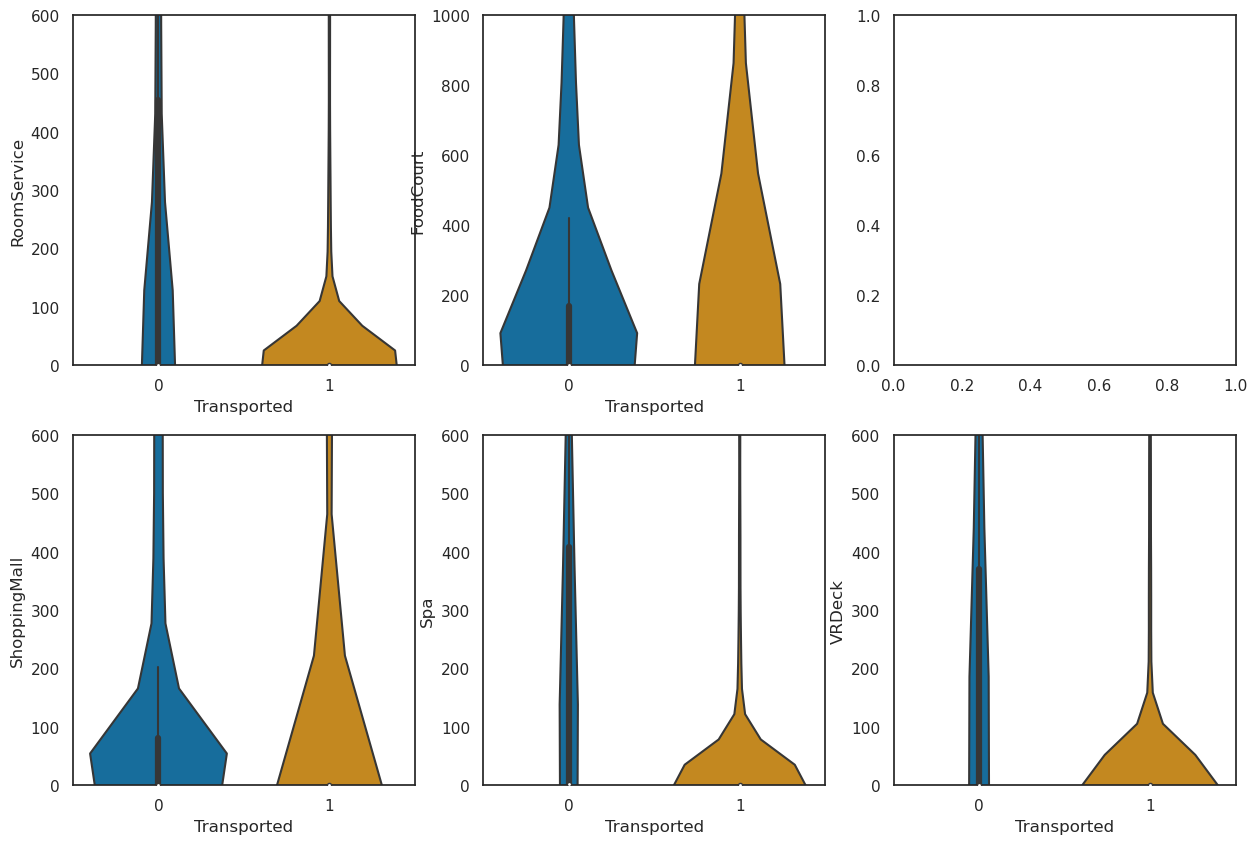

In [72]:
fig, axs = plt.subplots(2,3, figsize=(15, 10))
sns.violinplot(train, x='Transported', y='RoomService', ax=axs[0,0])
sns.violinplot(train, x='Transported', y='FoodCourt', ax=axs[0,1])
sns.violinplot(train, x='Transported', y='ShoppingMall', ax=axs[1,0])
sns.violinplot(train, x='Transported', y='Spa', ax=axs[1,1])
sns.violinplot(train, x='Transported', y='VRDeck', ax=axs[1,2])
axs[0,0].set_ylim(0, 600)
axs[0,1].set_ylim(0, 1000)
axs[1,0].set_ylim(0, 600)
axs[1,1].set_ylim(0, 600)
axs[1,2].set_ylim(0, 600)
plt.show()

**Let's try to deal with as follows:**
* We will leave FoodCourt and ShoppingMall as is for now. We will need to transform and scale later on. 
* For RoomService we will create three new features; NoRoomService (0), LowRoomService (1-100), LargeRoomService(>100)
* For Spa we will create three new features; NoSpa (0), LowSpa (1-100), LargeSpa(>100)
* For VRDeck we will create three new features; VRDeck (0), VRDeck (1-100), VRDeck(>100)

In [73]:
# Let's start with RoomService
#train['NoRoomService'] = 1
#train.loc[train['RoomService'] == 0, 'NoRoomService'] = 0

#predict['NoRoomService'] = 1
#predict.loc[predict['RoomService']  == 0, 'NoRoomService'] = 1

#train['LowRoomService'] = 0
#train.loc[(train['RoomService'] > 0) & (train['RoomService'] <=100), 'LowRoomService'] = 1

#predict['LowRoomService'] = 0
#predict.loc[(predict['RoomService'] > 0) & (predict['RoomService'] <=100), 'LowRoomService'] = 1

#train['LargeRoomService'] = 0
#train.loc[train['RoomService'] >100, 'LargeRoomService'] = 1

#predict['LargeRoomService'] = 0
#predict.loc[predict['RoomService']  > 100, 'LargeRoomService'] = 1

#train = train.drop(['RoomService'], axis=1)
#predict = predict.drop(['RoomService'], axis=1)

In [74]:
# Next is Spa
#train['NoSpa'] = 1
#train.loc[train['Spa'] == 0, 'NoSpa'] = 0

#predict['NoSpa'] = 1
#predict.loc[predict['Spa']  == 0, 'NoSpa'] = 1

#train['LowSpa'] = 0
#train.loc[(train['Spa'] > 0) & (train['Spa'] <=100), 'LowSpa'] = 1

#predict['LowSpa'] = 0
#predict.loc[(predict['Spa'] > 0) & (predict['Spa'] <=100), 'LowSpa'] = 1

#train['LargeSpa'] = 0
#train.loc[train['Spa'] >100, 'LargeSpa'] = 1

#predict['LargeSpa'] = 0
#predict.loc[predict['Spa']  > 100, 'LargeSpa'] = 1

#train = train.drop(['Spa'], axis=1)
#predict = predict.drop(['Spa'], axis=1)

In [75]:
# Finally VRDeck
#train['NoVRDeck'] = 1
#train.loc[train['VRDeck'] == 0, 'NoVRDeck'] = 0

#predict['NoVRDeck'] = 1
#predict.loc[predict['VRDeck']  == 0, 'NoVRDeck'] = 1

#train['LowVRDeck'] = 0
#train.loc[(train['VRDeck'] > 0) & (train['VRDeck'] <=100), 'LowVRDeck'] = 1

#predict['LowVRDeck'] = 0
#predict.loc[(predict['VRDeck'] > 0) & (predict['VRDeck'] <=100), 'LowVRDeck'] = 1

#train['LargeVRDeck'] = 0
#train.loc[train['VRDeck'] >100, 'LargeVRDeck'] = 1

#predict['LargeVRDeck'] = 0
#predict.loc[predict['VRDeck']  > 100, 'LargeVRDeck'] = 1

#train = train.drop(['VRDeck'], axis=1)
#predict = predict.drop(['VRDeck'], axis=1)

**Let's see if we have any improvment in our coorelations!**

<AxesSubplot:>

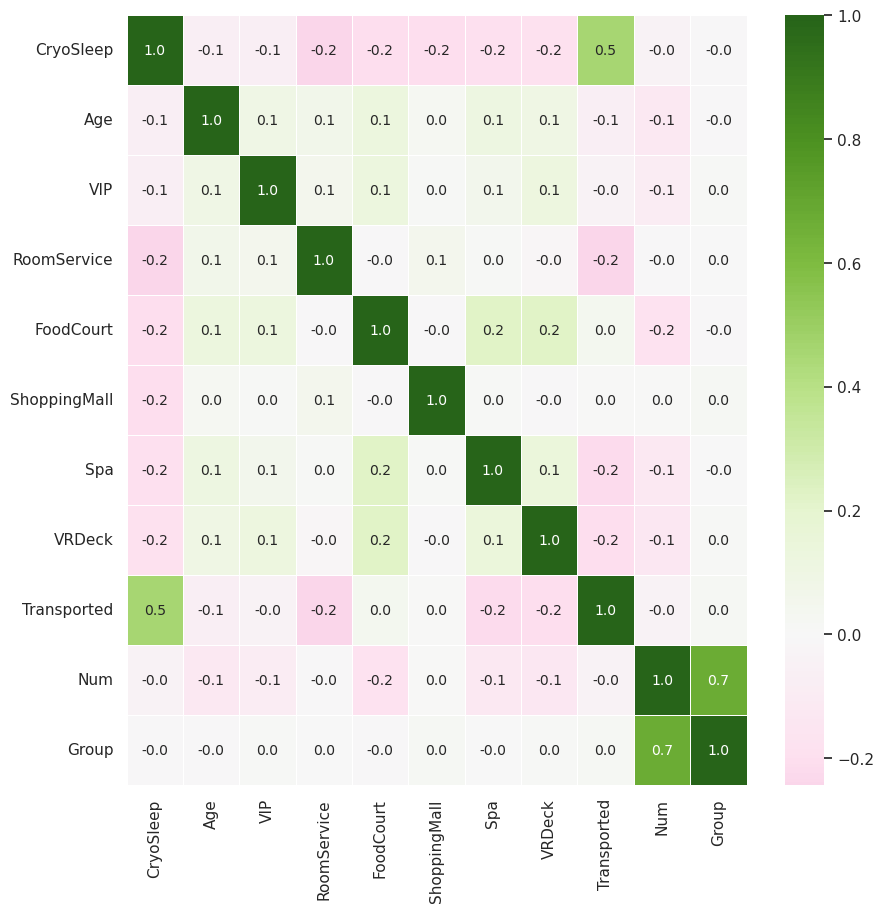

In [76]:
corr_matrix_3 = train.corr('pearson')
plt.subplots(figsize=(10, 10))
sns.heatmap(corr_matrix_3, cmap="PiYG", center=0, annot=True, linewidths=0.5, annot_kws={"size": 10}, fmt='.1f')

**We are starting to see some stronger coorelations with Transported**

# Let's see which continuous features are normally distributed

In [77]:
train.head()

PassengerId HomePlanet  CryoSleep  Destination   Age  VIP  RoomService  \
0     0001_01     Europa          0  TRAPPIST-1e  39.0    0          0.0   
1     0002_01      Earth          0  TRAPPIST-1e  24.0    0        109.0   
2     0003_01     Europa          0  TRAPPIST-1e  58.0    1         43.0   
3     0003_02     Europa          0  TRAPPIST-1e  33.0    0          0.0   
4     0004_01      Earth          0  TRAPPIST-1e  16.0    0        303.0   

   FoodCourt  ShoppingMall     Spa  VRDeck  Transported Deck  Num Side  Group  \
0        0.0           0.0     0.0     0.0            0    B  0.0    P      1   
1        9.0          25.0   549.0    44.0            1    F  0.0    S      2   
2     3576.0           0.0  6715.0    49.0            0    A  0.0    S      3   
3     1283.0         371.0  3329.0   193.0            0    A  0.0    S      3   
4       70.0         151.0   565.0     2.0            1    F  1.0    S      4   

  People  
0     01  
1     01  
2     01  
3     02  
4     01

In [78]:
numerical_features = train.select_dtypes(exclude = ["object"]).columns
print(numerical_features)

Index(['CryoSleep', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall',
       'Spa', 'VRDeck', 'Transported', 'Num', 'Group'],
      dtype='object')


In [79]:
numerical_features = [x for i,x in enumerate(numerical_features) if(x!='CryoSleep') and (x!='LowVRDeck') and (x!='LargeVRDeck')
                      and (x!='Transported') and (x!='Under10') and (x!='Individual') and (x!='SmallFam') and (x!='LargeRoomService')
                      and (x!='MediumFam') and (x!='LargeFam') and (x!='NoRoomService') and (x!='LowRoomService')  
                      and (x!='NoSpa') and (x!='LowSpa') and (x!='LargeSpa') and (x!='NoVRDeck') and (x!='VIP')]
numerical_features

['Age',
 'RoomService',
 'FoodCourt',
 'ShoppingMall',
 'Spa',
 'VRDeck',
 'Num',
 'Group']

In [80]:
skewed_features = train[numerical_features].apply(lambda x: skew(x)).sort_values(ascending=False)
high_skew = skewed_features[abs(skewed_features) > 0.5]
skew_index = high_skew.index
skew_index

Index(['ShoppingMall', 'VRDeck', 'Spa', 'FoodCourt', 'RoomService', 'Num'], dtype='object')

In literature, acceptable values for skewness are between -0.5 and 0.5 while -2 and 2 for Kurtosis.The non-normality of our distribution is also supported by the Shapiro test for normality (p-value really small that allows us to reject the hypotesis of normality).

# OneHotEncoding catagorical features that haven't been feature engineered

In [81]:
categorical_features = train.select_dtypes(include = ["object"]).columns
print(categorical_features)

Index(['PassengerId', 'HomePlanet', 'Destination', 'Deck', 'Side', 'People'], dtype='object')


In [82]:
categorical_features = [x for i,x in enumerate(categorical_features) if(x!='PassengerId')]
categorical_features

['HomePlanet', 'Destination', 'Deck', 'Side', 'People']

In [83]:
# Instantiate the OneHotEncoder Object
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(handle_unknown='ignore', sparse = False, )
# Apply ohe on data
ohe.fit(train[categorical_features])
cat_ohe = ohe.transform(train[categorical_features])

#Create a Pandas DataFrame of the hot encoded column
ohe_train = pd.DataFrame(cat_ohe, columns = ohe.get_feature_names(input_features = categorical_features))

In [84]:
train = train.drop(categorical_features, axis=1)

In [85]:
#concat with original data and drop original columns
train = pd.concat([train, ohe_train], axis=1)

**Let's do a final comparison to see if we have any improvment in coorelations!**

<AxesSubplot:>

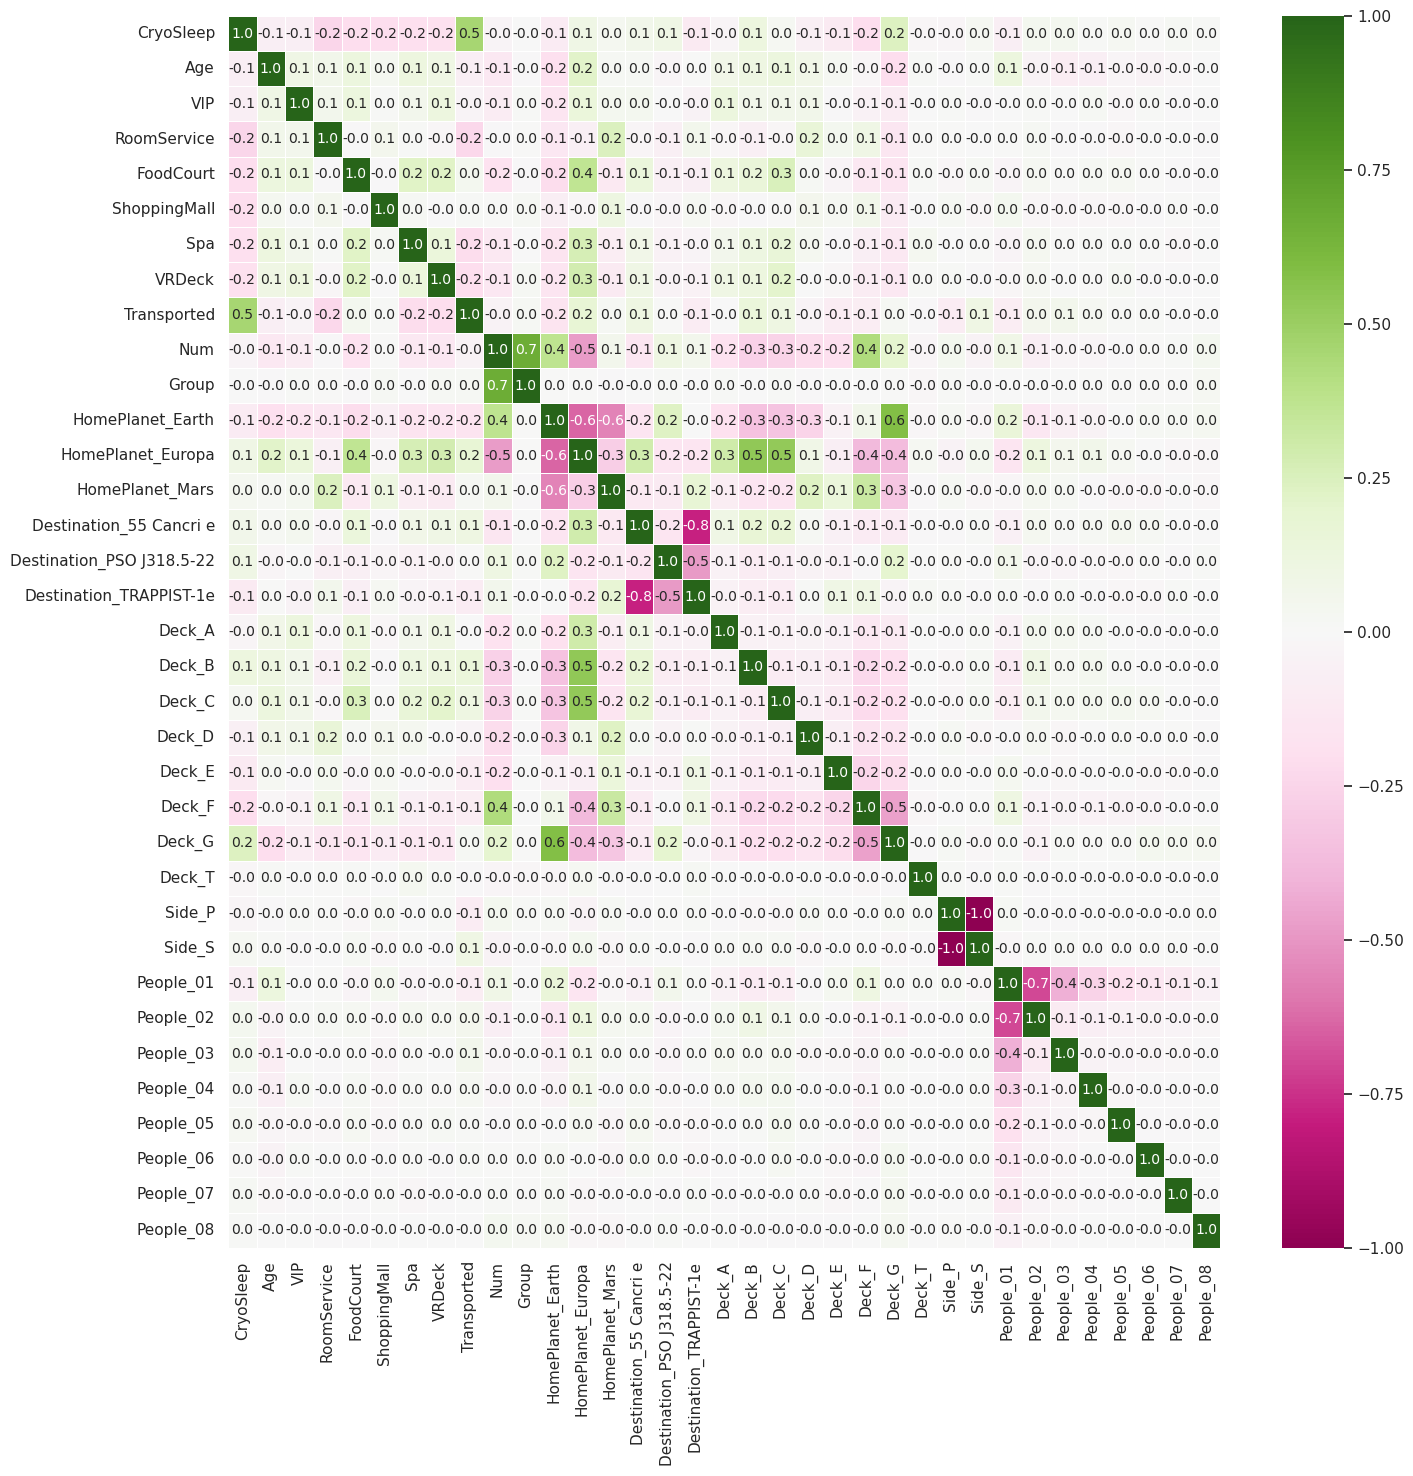

In [86]:
corr_matrix_4 = train.corr('pearson')
plt.subplots(figsize=(16, 16))
sns.heatmap(corr_matrix_4, cmap="PiYG", center=0, annot=True, linewidths=0.5, annot_kws={"size": 10}, fmt='.1f')

# Let's compare our coorelations at the start to where we are now

<AxesSubplot:>

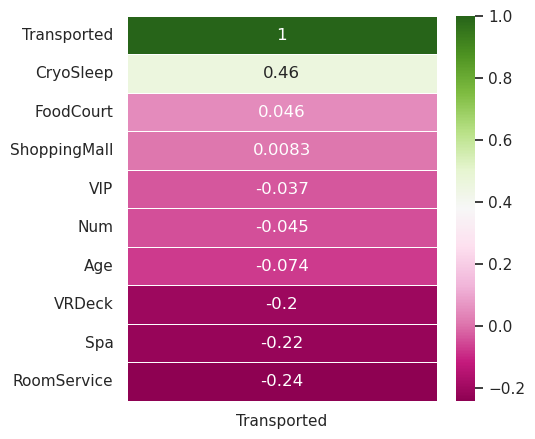

In [87]:
plt.figure(figsize=(5,5))
sns.heatmap(corr_matrix_1[['Transported']].sort_values(by=['Transported'], ascending=False), cmap="PiYG", annot=True, linewidths=0.5)

<AxesSubplot:>

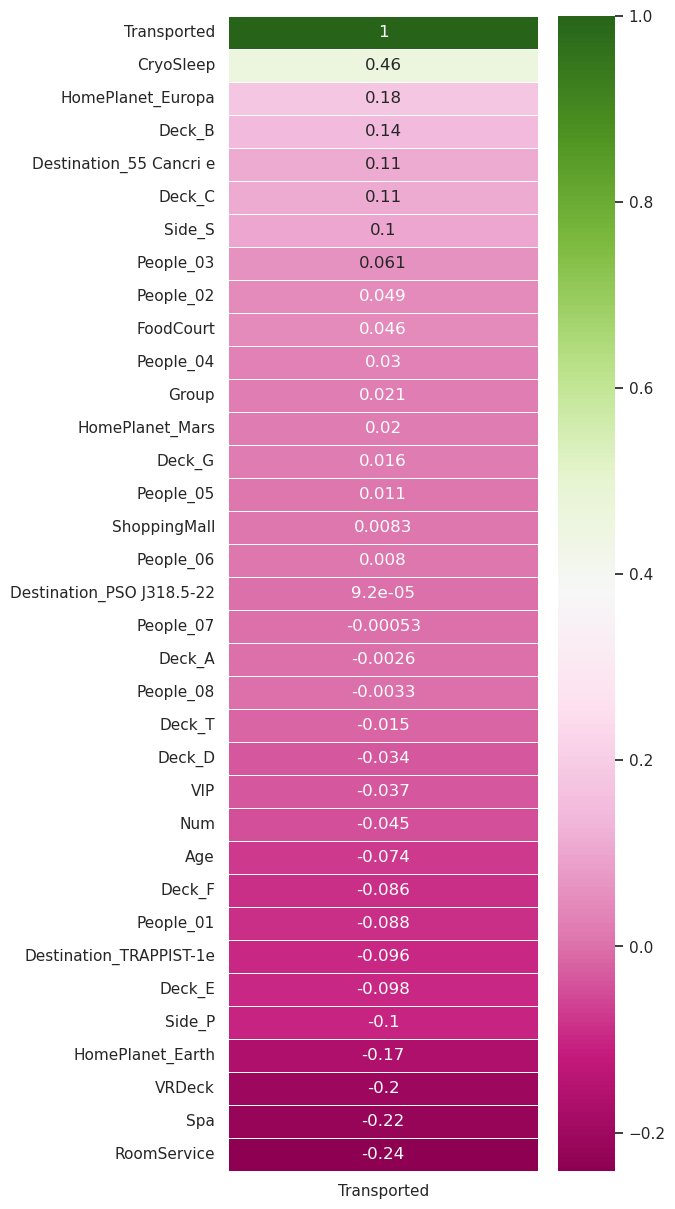

In [88]:
plt.figure(figsize=(5,15))
sns.heatmap(corr_matrix_4[['Transported']].sort_values(by=['Transported'], ascending=False), cmap="PiYG", annot=True, linewidths=0.5)

**While overall there aren't a lot of highely coorelated features, we can see an improvment.**
* Next time I'd like to do something we Num

#  Initial Assessment of a Variety of Models!

In [89]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PowerTransformer

import scikitplot as skplt
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, log_loss, roc_curve, roc_auc_score
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold, learning_curve
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

In [90]:
print(train.shape)
train.head()

(8693, 36)


PassengerId  CryoSleep   Age  VIP  RoomService  FoodCourt  ShoppingMall  \
0     0001_01          0  39.0    0          0.0        0.0           0.0   
1     0002_01          0  24.0    0        109.0        9.0          25.0   
2     0003_01          0  58.0    1         43.0     3576.0           0.0   
3     0003_02          0  33.0    0          0.0     1283.0         371.0   
4     0004_01          0  16.0    0        303.0       70.0         151.0   

      Spa  VRDeck  Transported  Num  Group  HomePlanet_Earth  \
0     0.0     0.0            0  0.0      1               0.0   
1   549.0    44.0            1  0.0      2               1.0   
2  6715.0    49.0            0  0.0      3               0.0   
3  3329.0   193.0            0  0.0      3               0.0   
4   565.0     2.0            1  1.0      4               1.0   

   HomePlanet_Europa  HomePlanet_Mars  Destination_55 Cancri e  \
0                1.0              0.0                      0.0   
1                0.0              0.0                      0.0   
2                1.0              0.0                      0.0   
3                1.0              0.0                      0.0   
4                0.0              0.0                      0.0   

   Destination_PSO J318.5-22  Destination_TRAPPIST-1e  Deck_A  Deck_B  Deck_C  \
0                        0.0                      1.0     0.0     1.0     0.0   
1                        0.0                      1.0     0.0     0.0     0.0   
2                        0.0                      1.0     1.0     0.0     0.0   
3                        0.0                      1.0     1.0     0.0     0.0   
4                        0.0                      1.0     0.0     0.0     0.0   

   Deck_D  Deck_E  Deck_F  Deck_G  Deck_T  Side_P  Side_S  People_01  \
0     0.0     0.0     0.0     0.0     0.0     1.0     0.0        1.0   
1     0.0     0.0     1.0     0.0     0.0     0.0     1.0        1.0   
2     0.0     0.0     0.0     0.0     0.0     0.0     1.0        1.0   
3     0.0     0.0     0.0     0.0     0.0     0.0     1.0        0.0   
4     0.0     0.0     1.0     0.0     0.0     0.0     1.0        1.0   

   People_02  People_03  People_04  People_05  People_06  People_07  People_08  
0        0.0        0.0        0.0        0.0        0.0        0.0        0.0  
1        0.0        0.0        0.0        0.0        0.0        0.0        0.0  
2        0.0        0.0        0.0        0.0        0.0        0.0        0.0  
3        1.0        0.0        0.0        0.0        0.0        0.0        0.0  
4        0.0        0.0        0.0        0.0        0.0        0.0        0.0

In [91]:
y = train['Transported']

In [92]:
X = train.drop(['Transported', 'PassengerId'], axis=1)

In [93]:
# Partition the dataset in train + validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

X_train : (6954, 34)
X_test : (1739, 34)
y_train : (6954,)
y_test : (1739,)


In [94]:
pt_x= PowerTransformer(method='yeo-johnson').fit(X_train[numerical_features])

X_train[numerical_features]  = pt_x.transform(X_train[numerical_features])
X_test[numerical_features]  = pt_x.transform(X_test[numerical_features])

In [95]:
X_train.head()

CryoSleep       Age  VIP  RoomService  FoodCourt  ShoppingMall  \
4278          0  1.642091    0    -0.695185   1.557340     -0.672688   
5971          0 -0.559786    0    -0.695185   1.028322      0.050149   
464           0  0.981827    0     1.652967  -0.705676      1.426429   
4475          0 -0.269550    0     1.496395  -0.705676      1.663329   
8469          1 -0.198849    0    -0.695185  -0.705676     -0.672688   

           Spa    VRDeck       Num     Group  HomePlanet_Earth  \
4278  1.709491  1.681739 -0.770885  0.070973               0.0   
5971  1.594917 -0.696421  1.250898  0.663010               1.0   
464   1.161473 -0.696421 -1.155386 -1.721761               0.0   
4475  1.647035  1.333637  0.771274  0.140609               1.0   
8469 -0.713922 -0.696421 -0.232732  1.486365               0.0   

      HomePlanet_Europa  HomePlanet_Mars  Destination_55 Cancri e  \
4278                1.0              0.0                      1.0   
5971                0.0              0.0                      0.0   
464                 0.0              1.0                      0.0   
4475                0.0              0.0                      0.0   
8469                1.0              0.0                      1.0   

      Destination_PSO J318.5-22  Destination_TRAPPIST-1e  Deck_A  Deck_B  \
4278                        0.0                      0.0     0.0     0.0   
5971                        0.0                      1.0     0.0     0.0   
464                         0.0                      1.0     0.0     0.0   
4475                        0.0                      1.0     0.0     0.0   
8469                        0.0                      0.0     0.0     0.0   

      Deck_C  Deck_D  Deck_E  Deck_F  Deck_G  Deck_T  Side_P  Side_S  \
4278     1.0     0.0     0.0     0.0     0.0     0.0     0.0     1.0   
5971     0.0     0.0     0.0     1.0     0.0     0.0     1.0     0.0   
464      0.0     0.0     0.0     1.0     0.0     0.0     0.0     1.0   
4475     0.0     0.0     0.0     1.0     0.0     0.0     0.0     1.0   
8469     1.0     0.0     0.0     0.0     0.0     0.0     0.0     1.0   

      People_01  People_02  People_03  People_04  People_05  People_06  \
4278        1.0        0.0        0.0        0.0        0.0        0.0   
5971        1.0        0.0        0.0        0.0        0.0        0.0   
464         0.0        1.0        0.0        0.0        0.0        0.0   
4475        1.0        0.0        0.0        0.0        0.0        0.0   
8469        1.0        0.0        0.0        0.0        0.0        0.0   

      People_07  People_08  
4278        0.0        0.0  
5971        0.0        0.0  
464         0.0        0.0  
4475        0.0        0.0  
8469        0.0        0.0

In [96]:
# 10 fold cross validatoin
kf = StratifiedKFold(n_splits=10)

In [97]:
# Modeling step Test differents algorithms 
random_state = 2
classifiers = []

classifiers.append(CatBoostClassifier(random_state=random_state, verbose=False))
classifiers.append(XGBClassifier(random_state=random_state))
classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LinearDiscriminantAnalysis())

In [98]:
cv_results_accuracy = []
for classifier in classifiers :
    cv_results_accuracy.append(cross_val_score(classifier, X_train, y = y_train, scoring = "accuracy", cv = kf, n_jobs=2))

cv_means_accuracy = []
for cv_result_accuracy in cv_results_accuracy:
    cv_means_accuracy.append(cv_result_accuracy.mean())

cv_accuracy = pd.DataFrame({"CrossValMeans Accuracy":cv_means_accuracy, "Algorithm":["CatBoost","XGB","SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting","KNeighboors","LinearDiscriminantAnalysis"]})

In [99]:
cv_accuracy

CrossValMeans Accuracy                   Algorithm
0                0.811766                    CatBoost
1                0.794508                         XGB
2                0.767479                         SVC
3                0.738857                DecisionTree
4                0.735261                    AdaBoost
5                0.797674                RandomForest
6                0.763593                  ExtraTrees
7                0.803426            GradientBoosting
8                0.735552                 KNeighboors
9                0.759423  LinearDiscriminantAnalysis

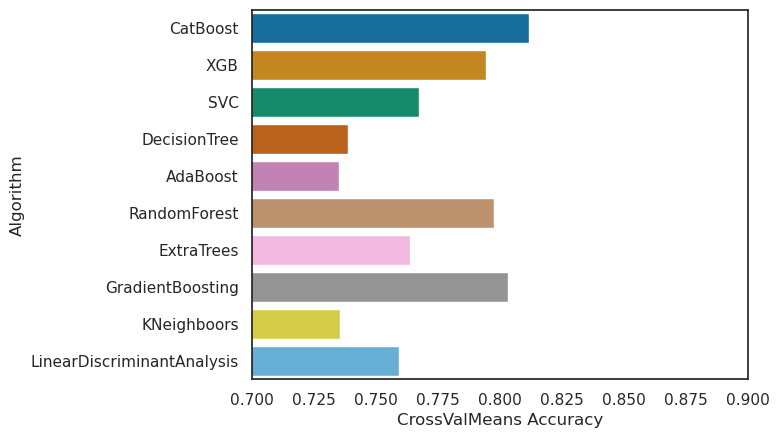

In [100]:
fig, ax = plt.subplots()
sns.barplot(x="CrossValMeans Accuracy",y="Algorithm",data = cv_accuracy, palette="colorblind", orient='h', ax=ax)
ax.set_xlim(0.7, 0.9)
plt.show()

In [101]:
cv_results_auc_roc = []
for classifier in classifiers :
    cv_results_auc_roc.append(cross_val_score(classifier, X_train, y = y_train, scoring = "roc_auc", cv = kf, n_jobs=2))

cv_means_auc_roc = []
for cv_result_auc_roc in cv_results_auc_roc:
    cv_means_auc_roc.append(cv_result_auc_roc.mean())

cv_auc_roc = pd.DataFrame({"CrossValMeans Auc Roc":cv_means_auc_roc, "Algorithm":["CatBoost","XGB","SVC","DecisionTree","AdaBoost",
"RandomForest","ExtraTrees","GradientBoosting", "KNeighboors","LinearDiscriminantAnalysis"]})

In [102]:
cv_auc_roc

CrossValMeans Auc Roc                   Algorithm
0               0.902061                    CatBoost
1               0.889539                         XGB
2               0.849773                         SVC
3               0.738827                DecisionTree
4               0.735239                    AdaBoost
5               0.881705                RandomForest
6               0.847114                  ExtraTrees
7               0.895334            GradientBoosting
8               0.805128                 KNeighboors
9               0.826193  LinearDiscriminantAnalysis

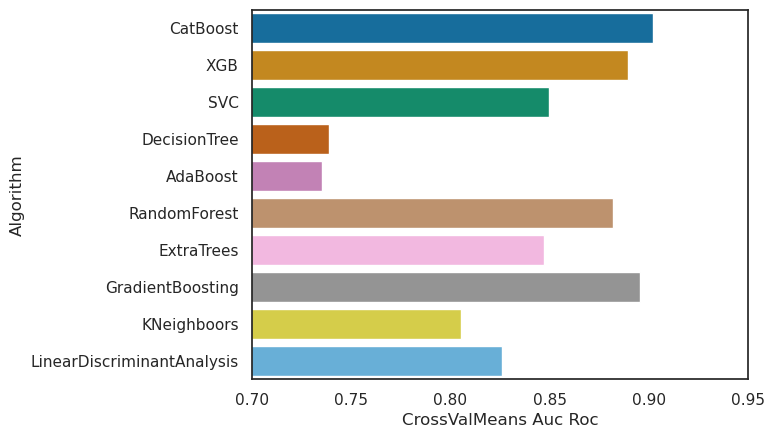

In [103]:
fig, ax = plt.subplots()
sns.barplot(x="CrossValMeans Auc Roc",y="Algorithm",data = cv_auc_roc, palette="colorblind", orient='h', ax=ax)
ax.set_xlim(0.7, 0.95)
plt.show()

**CatBoostClassifier looks a pretty good option!** 

Next I would do hyperparameter turning for the top few models, but my computer is crap so I won't

#  HyperParameter Tuning of Best Models!

* My computer isn't great so I avoid doing this :D

#  Select a Final Classifier!
**...Not complete...but good though for version 1!**

In [104]:
classifier = CatBoostClassifier(verbose = False,
                               thread_count=2)
classifier.fit(X_train, y_train)
y_test_predict = classifier.predict(X_test)
prob = classifier.predict_proba(X_test)
y_test_prob = prob[:,1]
y_train_predict = classifier.predict(X_train)

In [105]:
# Suggested to me that classification report and Auc_roc is best to use

# Accuracy is a good metric for a balanced dataset
result = accuracy_score(y_test, y_test_predict)
print('Accuracy is: ', result*100)

#Log loss is a cost function which tell us how different y_test_pred is from y_test (the higher LL, the larger the error)
ll = log_loss(y_test, y_test_predict)
print('Log Loss is: ', ll)

# TL: Truely predicted as positives, BR: Truely predicted as negatives, TR: Falsely predicted as negative, BL: Falsely predicted as positive
# Accuracy of confusion matrix is (TL+BR)/attributes 
# recall is Top box from confusion matrix TL / (TL+TR) true positive / total observed positives (closer to 1 the better)
# precision is left box from confusion matris TL / (TL+BL) true postives / all records predicted as positives (closer to 1 the better)
print(confusion_matrix(y_test, y_test_predict))

#F1 is accuracy
print(classification_report(y_test, y_test_predict))

#Area under ROC
fpr, tpr, threshold = roc_curve(y_test, y_test_prob)
print('roc_auc_score: ', roc_auc_score(y_test, y_test_prob)) # the higher the better the model is

Accuracy is:  81.65612420931569
Log Loss is:  6.335827948212887
[[694 169]
 [150 726]]
              precision    recall  f1-score   support

           0       0.82      0.80      0.81       863
           1       0.81      0.83      0.82       876

    accuracy                           0.82      1739
   macro avg       0.82      0.82      0.82      1739
weighted avg       0.82      0.82      0.82      1739

roc_auc_score:  0.9020440800647628


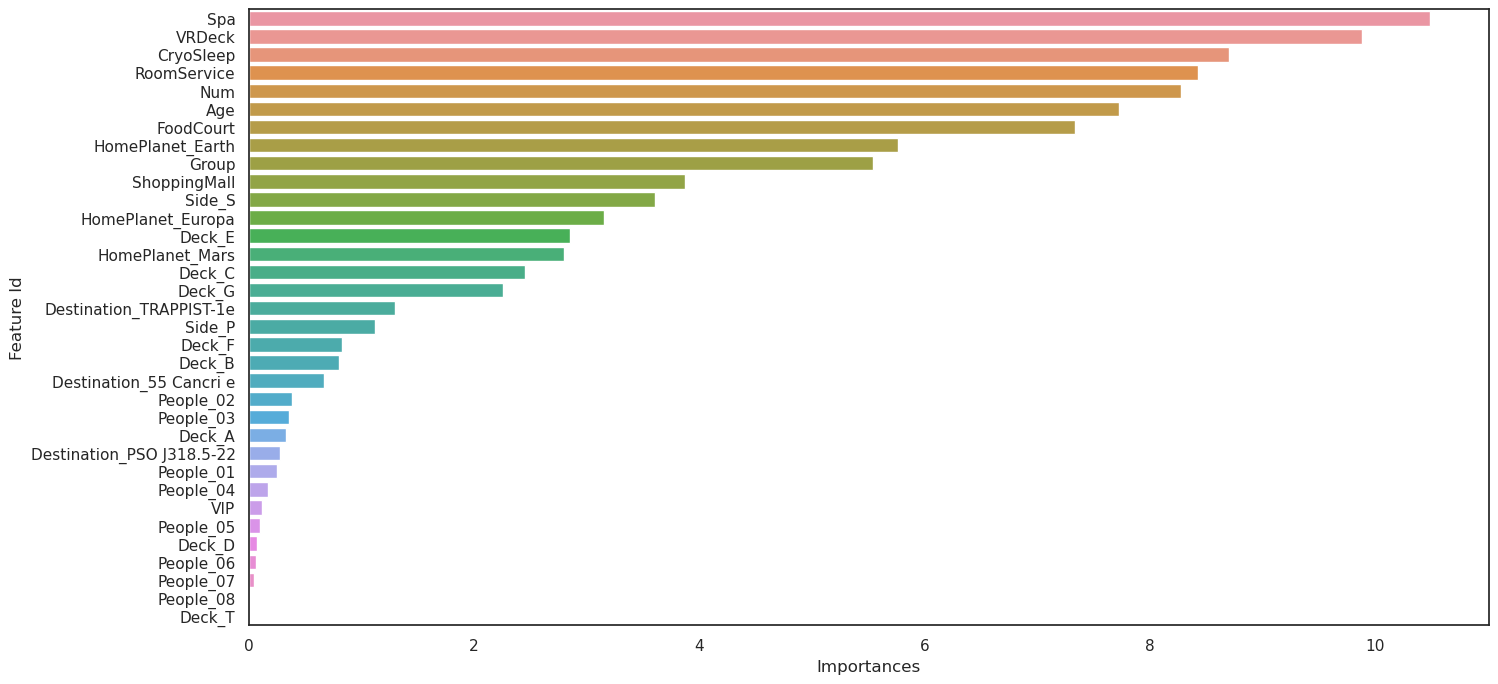

In [106]:
feat_imp = classifier.get_feature_importance(prettified=True)
plt.figure(figsize = (16,8))
sns.barplot(x=feat_imp['Importances'],y=feat_imp['Feature Id'], orient = 'h')
plt.show()

**Pretty interesting that some features I wouldn't have thought mattered from the pearson coorelation analysis are quite important!**
* Num and Age are pretty suprising! Makes me wonder if my feature engineering on some of the continuous features was necessary. I think I'll look back at this in version 2.

* Update: there are quite a few changes when I don't feature engineer as much. Seems CatBoost is better than me!

In [107]:
import shap

explainer = shap.TreeExplainer(classifier)
shap_values = explainer.shap_values(X_train)

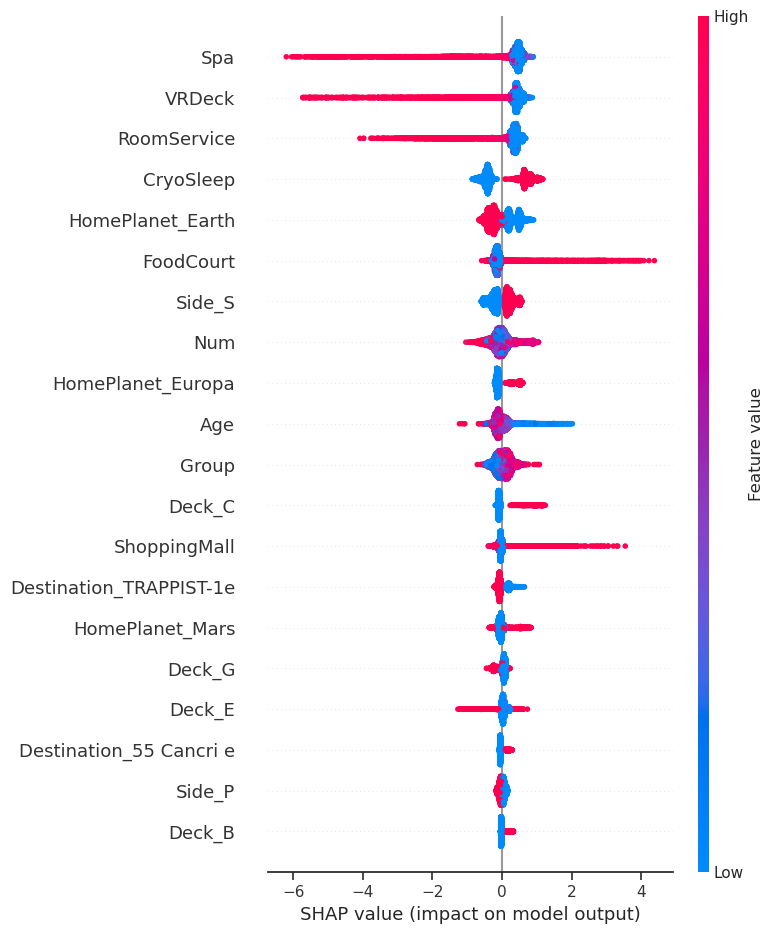

In [108]:
shap.summary_plot(shap_values, X_train)

#  Predict Transported on predict DataFrame!

In [109]:
print(predict.shape)
predict.head()

(4277, 16)


PassengerId HomePlanet  CryoSleep  Destination   Age  VIP  RoomService  \
0     0013_01      Earth          1  TRAPPIST-1e  27.0    0          0.0   
1     0018_01      Earth          0  TRAPPIST-1e  19.0    0          0.0   
2     0019_01     Europa          1  55 Cancri e  31.0    0          0.0   
3     0021_01     Europa          0  TRAPPIST-1e  38.0    0          0.0   
4     0023_01      Earth          0  TRAPPIST-1e  20.0    0         10.0   

   FoodCourt  ShoppingMall     Spa  VRDeck Deck  Num Side  Group People  
0        0.0           0.0     0.0     0.0    G  3.0    S     13     01  
1        9.0           0.0  2823.0     0.0    F  4.0    S     18     01  
2        0.0           0.0     0.0     0.0    C  0.0    S     19     01  
3     6652.0           0.0   181.0   585.0    C  1.0    S     21     01  
4        0.0         635.0     0.0     0.0    F  5.0    S     23     01

In [110]:
predict.dtypes

PassengerId      object
HomePlanet       object
CryoSleep         int64
Destination      object
Age             float64
VIP               int64
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Deck             object
Num             float64
Side             object
Group             int64
People           object
dtype: object

In [111]:
categorical_features

['HomePlanet', 'Destination', 'Deck', 'Side', 'People']

In [112]:
# The following code is for your test dataframe after training and testing on df dataframe
# Apply ohe on new dataframe
cat_ohe_predict = ohe.transform(predict[categorical_features])
#Create a Pandas DataFrame of the hot encoded column
ohe_df_predict = pd.DataFrame(cat_ohe_predict, columns = ohe.get_feature_names(input_features = categorical_features))

ohe_df_predict.head()

HomePlanet_Earth  HomePlanet_Europa  HomePlanet_Mars  \
0               1.0                0.0              0.0   
1               1.0                0.0              0.0   
2               0.0                1.0              0.0   
3               0.0                1.0              0.0   
4               1.0                0.0              0.0   

   Destination_55 Cancri e  Destination_PSO J318.5-22  \
0                      0.0                        0.0   
1                      0.0                        0.0   
2                      1.0                        0.0   
3                      0.0                        0.0   
4                      0.0                        0.0   

   Destination_TRAPPIST-1e  Deck_A  Deck_B  Deck_C  Deck_D  Deck_E  Deck_F  \
0                      1.0     0.0     0.0     0.0     0.0     0.0     0.0   
1                      1.0     0.0     0.0     0.0     0.0     0.0     1.0   
2                      0.0     0.0     0.0     1.0     0.0     0.0     0.0   
3                      1.0     0.0     0.0     1.0     0.0     0.0     0.0   
4                      1.0     0.0     0.0     0.0     0.0     0.0     1.0   

   Deck_G  Deck_T  Side_P  Side_S  People_01  People_02  People_03  People_04  \
0     1.0     0.0     0.0     1.0        1.0        0.0        0.0        0.0   
1     0.0     0.0     0.0     1.0        1.0        0.0        0.0        0.0   
2     0.0     0.0     0.0     1.0        1.0        0.0        0.0        0.0   
3     0.0     0.0     0.0     1.0        1.0        0.0        0.0        0.0   
4     0.0     0.0     0.0     1.0        1.0        0.0        0.0        0.0   

   People_05  People_06  People_07  People_08  
0        0.0        0.0        0.0        0.0  
1        0.0        0.0        0.0        0.0  
2        0.0        0.0        0.0        0.0  
3        0.0        0.0        0.0        0.0  
4        0.0        0.0        0.0        0.0

In [113]:
predict = predict.drop(categorical_features, axis=1)

In [114]:
#concat with original data and drop original columns
predict = pd.concat([predict, ohe_df_predict], axis=1)

In [115]:
predict[numerical_features]  = pt_x.transform(predict[numerical_features])

In [116]:
print(X_train.shape)
print(predict.shape)

(6954, 34)
(4277, 35)


In [117]:
predict_data = predict['PassengerId']
predict = predict.drop(['PassengerId'], axis=1)

In [118]:
predict[numerical_features].describe()

Age  RoomService    FoodCourt  ShoppingMall          Spa  \
count  4277.000000  4277.000000  4277.000000   4277.000000  4277.000000   
mean     -0.012353    -0.000148    -0.004207      0.020804     0.013904   
std       0.975345     0.998189     1.001477      1.009920     1.001188   
min      -2.421077    -0.695185    -0.705676     -0.672688    -0.713922   
25%      -0.559786    -0.695185    -0.705676     -0.672688    -0.713922   
50%      -0.128818    -0.695185    -0.705676     -0.672688    -0.713922   
75%       0.604611     1.299906     1.297434      1.318343     1.249313   
max       3.033294     1.703625     1.708375      1.745794     1.714025   

            VRDeck          Num        Group  
count  4277.000000  4277.000000  4277.000000  
mean     -0.019067     0.018085    -0.003739  
std       0.990497     1.006212     1.014063  
min      -0.696421    -2.493461    -2.162940  
25%      -0.696421    -0.722605    -0.821594  
50%      -0.696421     0.018229     0.099423  
75%       1.224063     0.919517     0.884681  
max       1.726068     1.780199     1.552647

In [119]:
X_train[numerical_features].describe()

Age   RoomService     FoodCourt  ShoppingMall           Spa  \
count  6.954000e+03  6.954000e+03  6.954000e+03  6.954000e+03  6.954000e+03   
mean   2.278560e-16 -1.634841e-17 -1.123953e-17  4.291457e-17  1.129062e-16   
std    1.000072e+00  1.000072e+00  1.000072e+00  1.000072e+00  1.000072e+00   
min   -2.421077e+00 -6.951846e-01 -7.056762e-01 -6.726878e-01 -7.139217e-01   
25%   -5.597858e-01 -6.951846e-01 -7.056762e-01 -6.726878e-01 -7.139217e-01   
50%   -5.942774e-02 -6.951846e-01 -7.056762e-01 -6.726878e-01 -7.139217e-01   
75%    6.524910e-01  1.287450e+00  1.276895e+00  1.247393e+00  1.267376e+00   
max    3.033294e+00  1.707261e+00  1.709895e+00  1.756216e+00  1.712935e+00   

             VRDeck           Num         Group  
count  6.954000e+03  6.954000e+03  6.954000e+03  
mean   1.476466e-16 -3.744807e-16  6.590452e-17  
std    1.000072e+00  1.000072e+00  1.000072e+00  
min   -6.964205e-01 -2.493461e+00 -2.191405e+00  
25%   -6.964205e-01 -7.545406e-01 -7.934456e-01  
50%   -6.964205e-01 -1.428859e-02  9.784639e-02  
75%    1.279118e+00  8.807570e-01  8.406694e-01  
max    1.727098e+00  1.781004e+00  1.553504e+00

**I think there might be a problem with the PowerTransformer (yeo-Johnson) used**
* If the prediction comes out crap and come back to this in the next version.
* Update: for this version I've not normalised or scaled any of the data. I've let CatBoost do it for me. It performed better :/

In [120]:
print(X_train.shape)
print(predict.shape)

(6954, 34)
(4277, 34)


In [121]:
predictions = classifier.predict(predict)

In [122]:
output = pd.DataFrame({'PassengerId': predict_data, 'Transported': predictions})
output.head()

PassengerId  Transported
0     0013_01            1
1     0018_01            0
2     0019_01            1
3     0021_01            1
4     0023_01            1

In [123]:
output['Transported'] = list(map(bool, output['Transported']))
output.head(2)

PassengerId  Transported
0     0013_01         True
1     0018_01        False

In [124]:
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!
